In [2]:
import os

import pandas as pd
import numpy as np

import squarify
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")

In [3]:
data_path = os.path.join('..','data','01_raw','data.csv')

In [4]:
df = pd.read_csv(data_path)

# 1. Qualidade dos Dados
Checagem básica do dataset
* Valores invalidos?
* Duplicados?

In [5]:
# Visão geral dos dados
df.head()

stone_tpv_acquirer_total  cnae_fiscal_principal  segmento  uf  \
0                   4764.00                    428         5  SP   
1                  23929.99                    309         2  SP   
2                   6225.50                    369         0  MG   
3                  35448.28                    280         0  PI   
4                  13848.26                    300        16  GO   

          municipio        bairro  mei  capital_social  total_estab  mcc  \
0              MAUA  VILA BOCAINA    0          100000            1  163   
1         SAO PAULO   VILA BARUEL    0           10000            1   95   
2  SAO JOSE DA LAPA   DOM PEDRO I    1            1000            1   59   
3          TERESINA     PRIMAVERA    0          100000            1   57   
4          MINEIROS      SAO JOAO    0           10000            1   46   

   subsegmento  porte  faixa_empregados  tier  
0           31      2                 0     0  
1            3      2                 1     2  
2           13      3                 0     0  
3           13      2                 1     2  
4           48      2                 0     0

In [6]:
# Checando tipo de dados e qualquer valor null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   stone_tpv_acquirer_total  100000 non-null  float64
 1   cnae_fiscal_principal     100000 non-null  int64  
 2   segmento                  100000 non-null  int64  
 3   uf                        100000 non-null  object 
 4   municipio                 100000 non-null  object 
 5   bairro                    99945 non-null   object 
 6   mei                       100000 non-null  int64  
 7   capital_social            100000 non-null  int64  
 8   total_estab               100000 non-null  int64  
 9   mcc                       100000 non-null  int64  
 10  subsegmento               100000 non-null  int64  
 11  porte                     100000 non-null  int64  
 12  faixa_empregados          100000 non-null  int64  
 13  tier                      100000 non-null  in

* Há apenas 55 valores invalidos em bairro
* bairro não é uma variável fácil de preencher devido a sua natureza
* Solução mais prática seria descartar esses valores e trabalhar com os demais

In [7]:
# Checando duplicidade dos daods
df.duplicated().sum()

0

In [8]:
# Checando a unicidade dos valores
df.nunique().sort_values()

mei                             2
porte                           4
faixa_empregados                5
tier                            5
uf                             27
segmento                       28
total_estab                    67
subsegmento                    71
mcc                           166
cnae_fiscal_principal         477
capital_social               1437
municipio                    3820
bairro                      16537
stone_tpv_acquirer_total    90725
dtype: int64

* As variáveis cnae, segmento, subsegmento, municipio, bairro, uf e tier são categóricas por definição
* mei, porte, faixa_empregados serão tratadas como categóricas devido a poucos valores únicos
* capital_social e total_estab aparentam ser as única variáveis que poderão ser tratada como numérica além da variável alvo
* Deveremos explorar mais esses dados a fim de decidir se:
  1. Iremos realmente tratar todas essas variáveis como categóricas
  2. Escolher um modelo que consiga lidar apropriadamente com essas variáveis

# 2 - Análise Exploratória dos Dados
Com nossa observação inical conseguimods definir e organizar um **dicionário de dados** da seguinte forma:

* **Dados de tamanho do cliente**:
    * porte - Faixa do tamanho dos clientes
    * total_estab - Numero de estabelecimentos que o cliente possui
    * faixa_empregados - Faixa de número de empregados
    * capital_social - Investimento bruto inicial da empresa

* **Dados geográficos do cliente**:
    * uf - Sigla do estado
    * municipio - Nome da cidade
    * bairro - Nome do bairro

* **Dados mercadológicos do cliente**:
    * mei - Classifica se o cliente é MEI ou não
    * segmento - Segmento de mercado do cliente
    * subsegmento - Subsegmento de mercado do cliente
    * mcc - Merchant category code: um número de quatro digitos para serviços financeiros de varejo.
    * cnae_fiscal_principal - Classificação nacional de atividades econômicas: um código nacional que categoriza empresas
* **Outros dados** :
    * tier - Alguma classificação de desempenho do cliente (ainda é preciso explorar mais para entender em relação ao que essa tier se refere)
* **Variável Dependente**:
    * stone_tpv_acquirer_total - O Total payment volume é valor total de transações processadas por uma tecnologia de pagamentos em um determinado período de tempo.


De posse deste dicionário, iremos tentar responder algumas perguntas relacionadas ao TPV e as variáveis dependentes:
1. Como o **capital social** influencia o TPV? 
2. A **geografia** é relevante para o modelo?
3. Quão importante é o **segmento** e **tamanho** da empresa?
4. O **tier** está atrelado a alguma das variáveis? O que ele está rankeando?
5. Podemos desprezar alguma variável?

## 2.1 - Análise das Variáveis Numéricas

Vamos inicialmente identificar e alterar todas as variáveis que possuem nomes ou códigos como categóricas,
deixando apenas stone_tpv_acquirer_total ,capital_social e total_estab como numéricas.

In [5]:
# Função para identificar variáveis que podem ser convertidas em categóricas
def find_categorical_features(df: pd.DataFrame, threshold=0.05):
    cat_features = []
    exclude_columns = ['stone_tpv_acquirer_total', 'capital_social', 'total_estab']
    for column_name in df.columns:
        if column_name not in exclude_columns and df[column_name].nunique() / len(df[column_name]) < threshold:
            cat_features.append(column_name)
    return cat_features

# Função para converter variáveis em categóricas
def convert_to_categorical(df: pd.DataFrame, columns):
    df[columns] = df[columns].astype('object')
    return df

In [6]:
threshold = 0.01

categorical_features = find_categorical_features(df, threshold)
df_tmp = convert_to_categorical(df, categorical_features)
df_tmp.info()
del df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   stone_tpv_acquirer_total  100000 non-null  float64
 1   cnae_fiscal_principal     100000 non-null  object 
 2   segmento                  100000 non-null  object 
 3   uf                        100000 non-null  object 
 4   municipio                 100000 non-null  object 
 5   bairro                    99945 non-null   object 
 6   mei                       100000 non-null  object 
 7   capital_social            100000 non-null  int64  
 8   total_estab               100000 non-null  int64  
 9   mcc                       100000 non-null  object 
 10  subsegmento               100000 non-null  object 
 11  porte                     100000 non-null  object 
 12  faixa_empregados          100000 non-null  object 
 13  tier                      100000 non-null  ob

In [10]:
# Estatísticas descritivas para as variáveis numéricas
print("Estatísticas Descritivas para variáveis numéricas:")
df_tmp.describe()

Estatísticas Descritivas para variáveis numéricas:


stone_tpv_acquirer_total  capital_social   total_estab
count              1.000000e+05    1.000000e+05  100000.00000
mean               3.932034e+04    2.458882e+06       1.68003
std                9.583459e+04    9.290004e+07      12.24178
min                1.000000e-02    0.000000e+00       1.00000
25%                6.235007e+03    5.000000e+03       1.00000
50%                1.743474e+04    2.000000e+04       1.00000
75%                4.132161e+04    6.000000e+04       1.00000
max                9.932116e+06    4.704203e+09    2072.00000

* **stone_tpv_acquirer_total** apresenta valor máximo na casa de milhões de reais e não possui nenhum valor nulo
* **capita_social** possui máximo na casa de bilhões, porém possui valores nulos, o que é um indício que esta amostra é composta por empresas de vários tamanhos
* **total_estab** apresenta poucos resultados $(<25\%)$ com valores acima de 1

**Visualização Univariada**

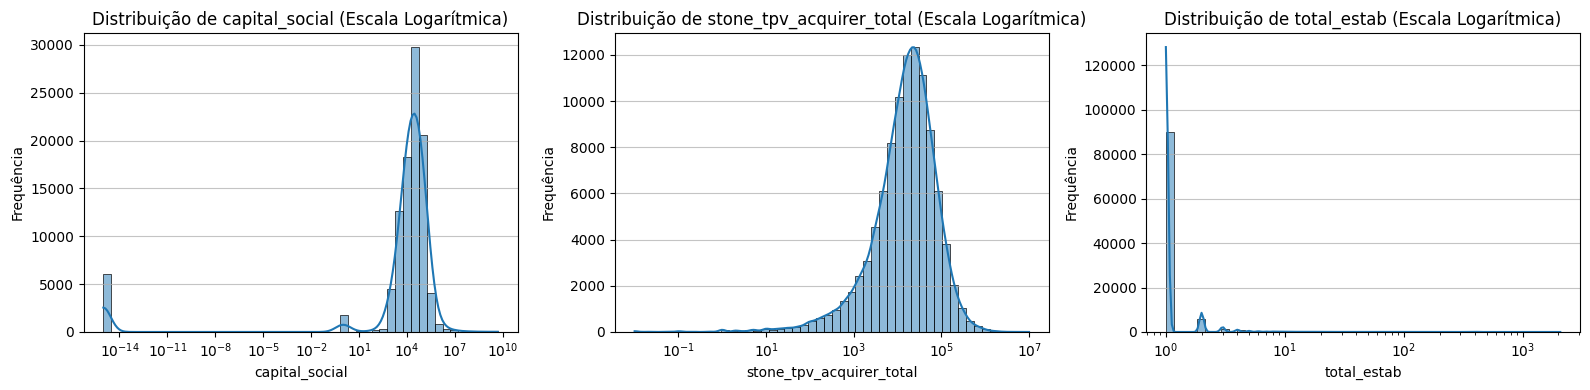

In [11]:
# Histogramas das variáveis
small_constant = 1e-15

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# Gerando gráficos das Variáveis com escala logaritmica
sns.histplot(df_tmp['capital_social']+small_constant, bins=50, palette='Spectral', edgecolor='black', log_scale=True, ax=axs[0], kde=True)
axs[0].set_title('Distribuição de capital_social (Escala Logarítmica)')
axs[0].set_xlabel('capital_social')
axs[0].set_ylabel('Frequência')
axs[0].grid(axis='y', alpha=0.75)

sns.histplot(df_tmp['stone_tpv_acquirer_total'], bins=50, palette='Spectral', edgecolor='black', log_scale=True, ax=axs[1], kde=True)
axs[1].set_title('Distribuição de stone_tpv_acquirer_total (Escala Logarítmica)')
axs[1].set_xlabel('stone_tpv_acquirer_total')
axs[1].set_ylabel('Frequência')
axs[1].grid(axis='y', alpha=0.75)

sns.histplot(df_tmp['total_estab'], bins=50, palette='Spectral', edgecolor='black', log_scale=True, ax=axs[2], kde=True)
axs[2].set_title('Distribuição de total_estab (Escala Logarítmica)')
axs[2].set_xlabel('total_estab')
axs[2].set_ylabel('Frequência')
axs[2].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()


* Ambas as distribuições de **capital_social** e **stone_tpv_acquirer_total** são deslocadas para a direita, indicando uma **distribuição assimétrica positiva** para ambas.
* Apesar de similares num primeiro olhar, capital social possui uma quantidade alta de valores em 0, enquanto o TPV tem uma distribuição simétrica ao redor do ponto de máximo
* A distribuição de **total_estab** possui máximo em 1 e alguns poucos exemplares com valor acima disso

**Visualização Multivariada**

<Figure size 1000x400 with 0 Axes>

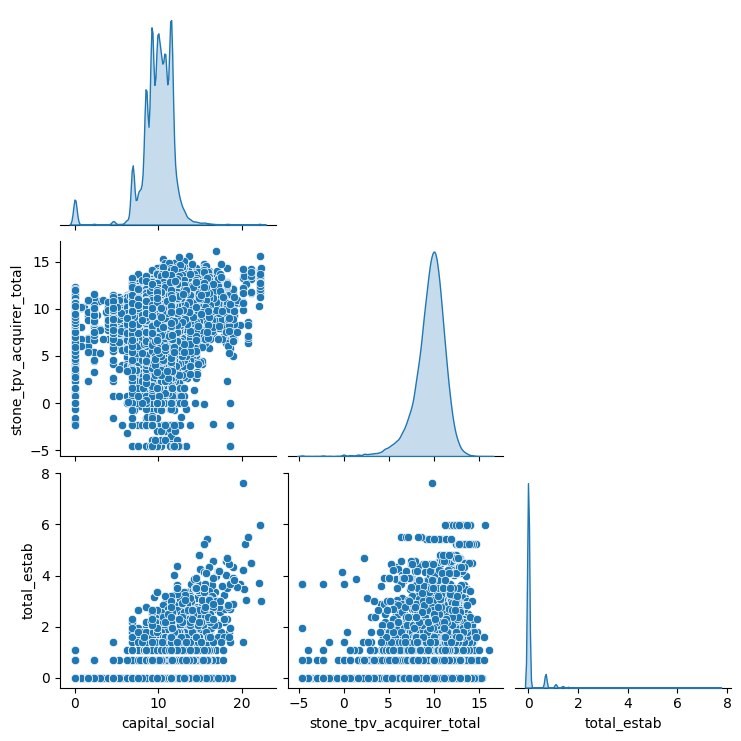

In [12]:
# Gráficos de dispersão
vars_of_interest = ['capital_social', 'stone_tpv_acquirer_total', 'total_estab']
data_of_interest = df_tmp[vars_of_interest]

data_of_interest_log = np.log(data_of_interest)

plt.figure(figsize=(10,4),tight_layout=True)
sns.pairplot(data_of_interest_log, diag_kind='kde', corner=True)
plt.show()


* O gráfico de dispersão evidencia há alguma relação positiva entre as variáveis
* **capital_social** e **total_estab** parecem ter relação linear entre si
* O mesmo não pode ser dito para estas variáveis com relação a **stone_tpv_acquirer_total**

**Correlação**

Com poucas variáveis numéricas podemos calcular rapidamente o valor das correlações entre essas duas variáveis e entender a relação entre elas

In [13]:
# Cálculo das correlações
corr_pearson = df_tmp.select_dtypes(exclude=object).corr(method='pearson')
corr_spearman = df_tmp.select_dtypes(exclude=object).corr(method='spearman')

In [14]:
print("\nCorrelação de Pearson (Linear):")
corr_pearson


Correlação de Pearson (Linear):


stone_tpv_acquirer_total  capital_social  \
stone_tpv_acquirer_total                  1.000000        0.119932   
capital_social                            0.119932        1.000000   
total_estab                               0.130026        0.715363   

                          total_estab  
stone_tpv_acquirer_total     0.130026  
capital_social               0.715363  
total_estab                  1.000000

In [15]:
print("\nCorrelação de Spearman (Não Linear):")
corr_spearman


Correlação de Spearman (Não Linear):


stone_tpv_acquirer_total  capital_social  \
stone_tpv_acquirer_total                   1.00000        0.200960   
capital_social                             0.20096        1.000000   
total_estab                                0.11883        0.183306   

                          total_estab  
stone_tpv_acquirer_total     0.118830  
capital_social               0.183306  
total_estab                  1.000000

* **total_estab** e **capital_social** possuem correlação linear positiva forte entre si
* Ambas possuem uma correlação positiva fraca com a variável alvo. Com relação aos coeficientes de correlação calculados podemos inferir que: 
    * **total_estab** e **stone_tpv_acquirer_total** parecem ter relação linear $(\text Pearson > \text Spearman)$
    * **capital_social** e **stone_tpv_acquirer_total** possuem relação não linear $(\text Spearmn > \text Pearson)$



**Conlusões**
* Há correlação positiva entre as três variáveis numéricas, mas a correlação entre as variáveis dependentes é fraca e não linear com a variável alvo
* O total de estabelecimentos e o capital social possuem forte correlação linear
* Devemos idealmente buscar um modelo que seja **robusto a multicolinearidades**

## 2.2 - Análise das Variáveis Categóricas

In [65]:
# Função de remoção de outliers pelo método de Tukey
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

In [17]:
# Contagem das categorias
df_tmp.select_dtypes(object).nunique().sort_values()

mei                          2
porte                        4
faixa_empregados             5
tier                         5
uf                          27
segmento                    28
subsegmento                 71
mcc                        166
cnae_fiscal_principal      477
municipio                 3820
bairro                   16537
dtype: int64

In [18]:
# Estatísticas descritivas para as variáveis categóricas
print("Estatísticas Descritivas para Variáveis Categóricas:")
(df_tmp.describe(include=object))

Estatísticas Descritivas para Variáveis Categóricas:


cnae_fiscal_principal  segmento      uf  municipio  bairro     mei  \
count                  100000    100000  100000     100000   99945  100000   
unique                    477        28      27       3820   16537       2   
top                       331         0      SP  SAO PAULO  CENTRO       0   
freq                     8051     28653   23289       6318   26668   79057   

           mcc  subsegmento   porte  faixa_empregados    tier  
count   100000       100000  100000            100000  100000  
unique     166           71       4                 5       5  
top         68           13       2                 0       2  
freq      8051        10771   63819             60826   48318

### 2.2.1 - Dados de Tamanho

**Análise Univariada**

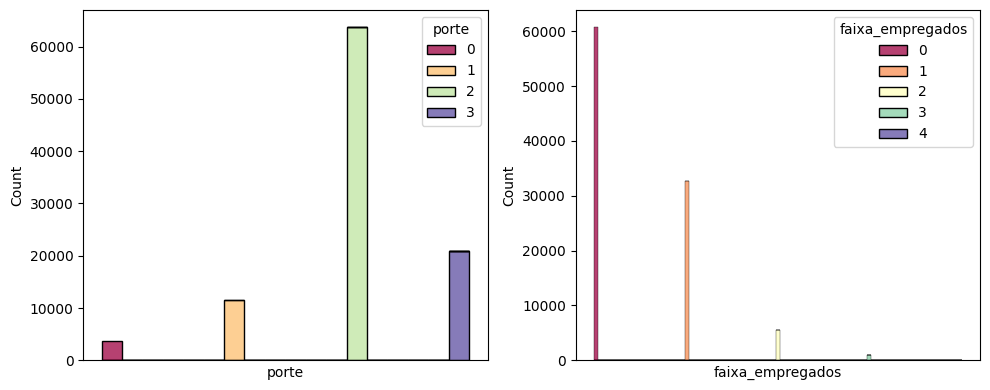

In [19]:
# Histogramas
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(data=df_tmp, x='porte',  multiple='stack', hue='porte', ax=axes[0],palette='Spectral')
axes[0].set_xticks([])

sns.histplot(data=df_tmp, x='faixa_empregados', multiple='stack', hue='faixa_empregados', ax=axes[1],palette='Spectral')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()


**Análise Multivariada**

In [20]:
# Matriz de contingência
print('Matriz de contingência')
contingency_table = pd.crosstab(df_tmp['porte'], df_tmp['faixa_empregados'])

contingency_table

Matriz de contingência


faixa_empregados      0      1     2    3   4
porte                                        
0                  1006   1441   848  351  60
1                  3981   5514  1757  275   5
2                 34896  25693  2913  311   6
3                 20943      0     0    0   0

A titulo de curiosidade realizaremos um teste de Qui-Quadrado entre essas duas variáveis com a hipótese nula:
* $H_0$: Não há associação entre porte e faixa_empregados

In [21]:
# Teste Qui-quadrado
res = chi2_contingency(contingency_table)

print(f"Qui-quadrado: {res.statistic}")
print(f"P-valor: {res.pvalue}")

Qui-quadrado: 26542.552476881
P-valor: 0.0


* A matriz de contigência e o teste $\chi^2$, assumindo um nível de significância $\alpha$ de 5%, faz com que rejeitemos a hipótese nula, o que não é um resultado surpreendente pela prórpia definição das variáveis.

Vamos analisar a relação dessas duas variáveis com relação as variáveis numéricas

In [63]:
def plot_combined(df, numerical_cols, categorical_col, max_categories=None):
    # Plot pairplot
    data_of_interest = df[numerical_cols + [categorical_col]]
    data_of_interest_log = data_of_interest.copy()
    for col in numerical_cols:
        data_of_interest_log[col] = np.log(data_of_interest[col])

    if max_categories is not None and len(data_of_interest_log[categorical_col].unique()) > max_categories:
        top_categories = data_of_interest_log[categorical_col].value_counts().nlargest(max_categories).index
        data_of_interest_log = data_of_interest_log[data_of_interest_log[categorical_col].isin(top_categories)]

    sns.pairplot(data_of_interest_log, diag_kind='kde', hue=categorical_col, corner=True)
    plt.show()

    # Plot violinplot
    df_log = df[numerical_cols].apply(lambda x: np.log(x + 1))
    fig, axs = plt.subplots(1, len(numerical_cols), figsize=(20, 6))

    for i, col in enumerate(numerical_cols):
        top_categories = df[categorical_col].value_counts().nlargest(max_categories if max_categories is not None else len(df)).index
        df_top_categories = df[df[categorical_col].isin(top_categories)]

        sns.violinplot(x=df_top_categories[categorical_col], y=df_log[col], ax=axs[i], palette='Spectral')
        axs[i].set_xlabel(categorical_col)
        axs[i].set_ylabel(f'Log({col})')
        axs[i].set_title(f'Violinplot do Log({col}) por {categorical_col}')
        axs[i].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    # Plot barplot
    df_bar = df.copy()
    if 'capital_social' in numerical_cols:
        df_bar['capital_social'] = remove_outliers(df['capital_social'])

    barplot = df_bar.groupby(categorical_col, as_index=False)[numerical_cols].mean()

    top_categories = barplot[categorical_col].value_counts().nlargest(max_categories if max_categories is not None else len(df)).index
    barplot_top_categories = barplot[barplot[categorical_col].isin(top_categories)]

    plt.figure(figsize=(16, 6), tight_layout=True)

    for i, col in enumerate(numerical_cols):
        plt.subplot(1, len(numerical_cols), i+1)
        sns.barplot(x=categorical_col, y=col, data=barplot_top_categories.sort_values(col, ascending=False), color='skyblue', edgecolor='black')
        plt.title(f'Média de {col} por {categorical_col}')
        plt.xlabel(categorical_col)
        plt.ylabel(f'Média {col}')
        plt.tick_params(axis="x", labelsize=10, rotation=90)

    plt.show()


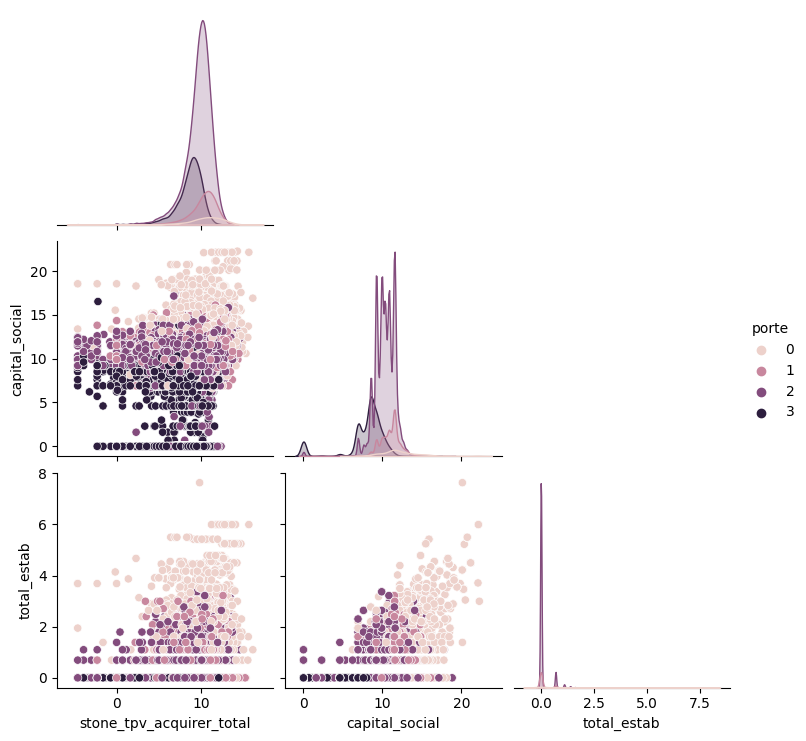

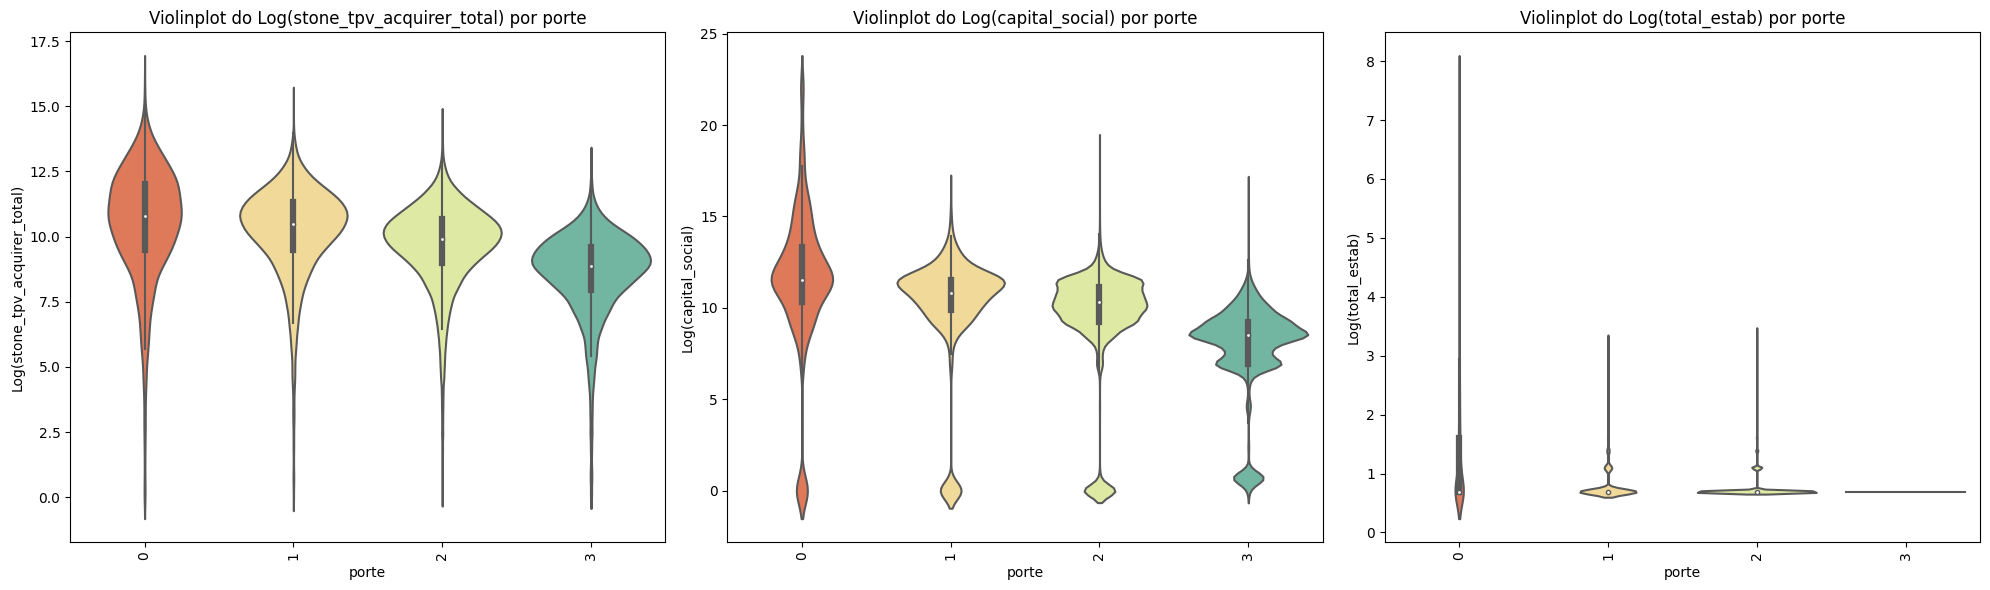

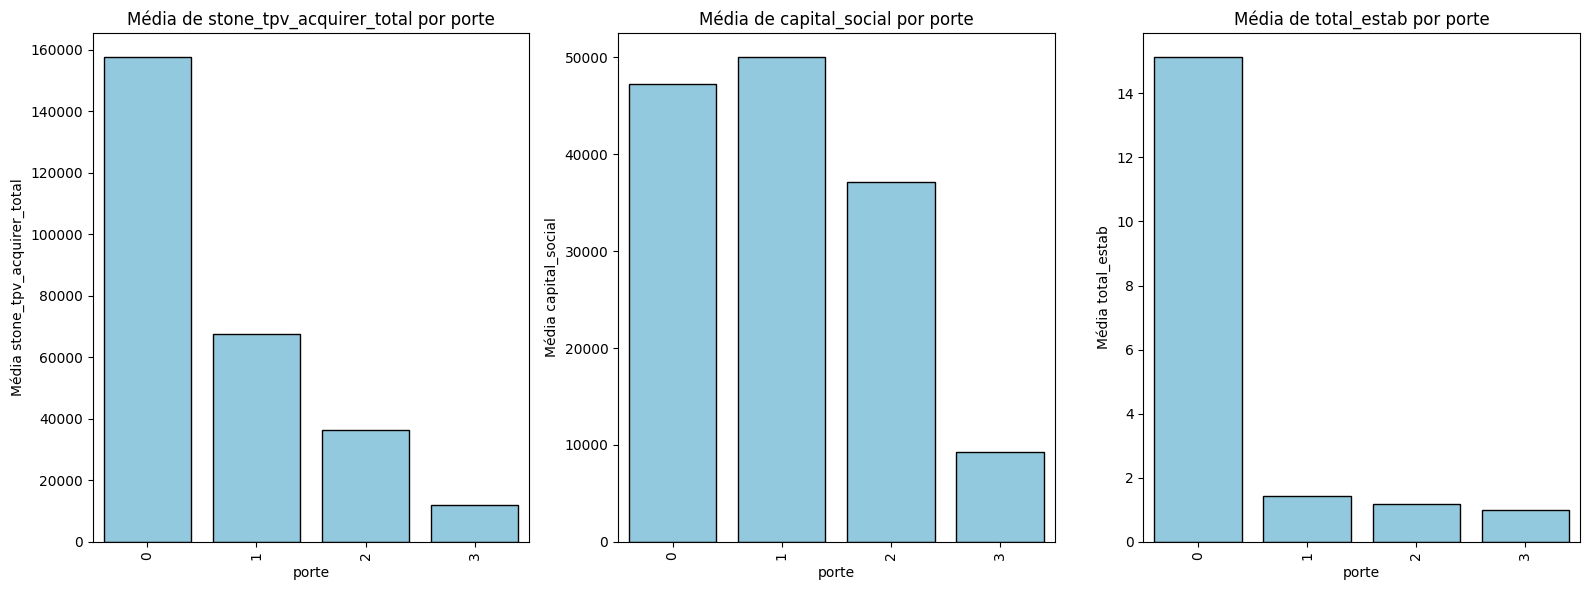

In [130]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'porte')

* Desses gráficos concluimos que as empresas de porte **0** estão associadas a valores altos de **TPV**, **capital social** e **total de estabelecimentos**
* Em particular olhando para o gráfico de **TPV** x **Capital Social** podemos inferir que o porte está relacionado de maneira positiva com estas duas variáveis
* As empresas de porte **3** tendem a estar em patamares mais baixos em todos gráficos
* Consideramos seguro inferir que o porte está em ordem decrescente, onde **3** representa empresas de pequeno porte e **0** são empresas de maior porte

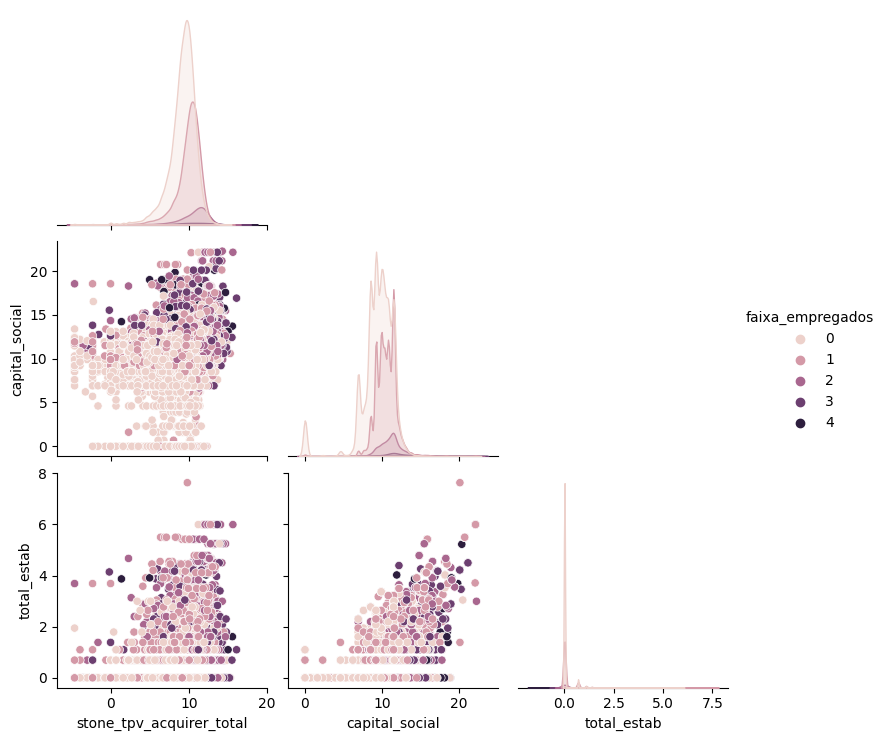

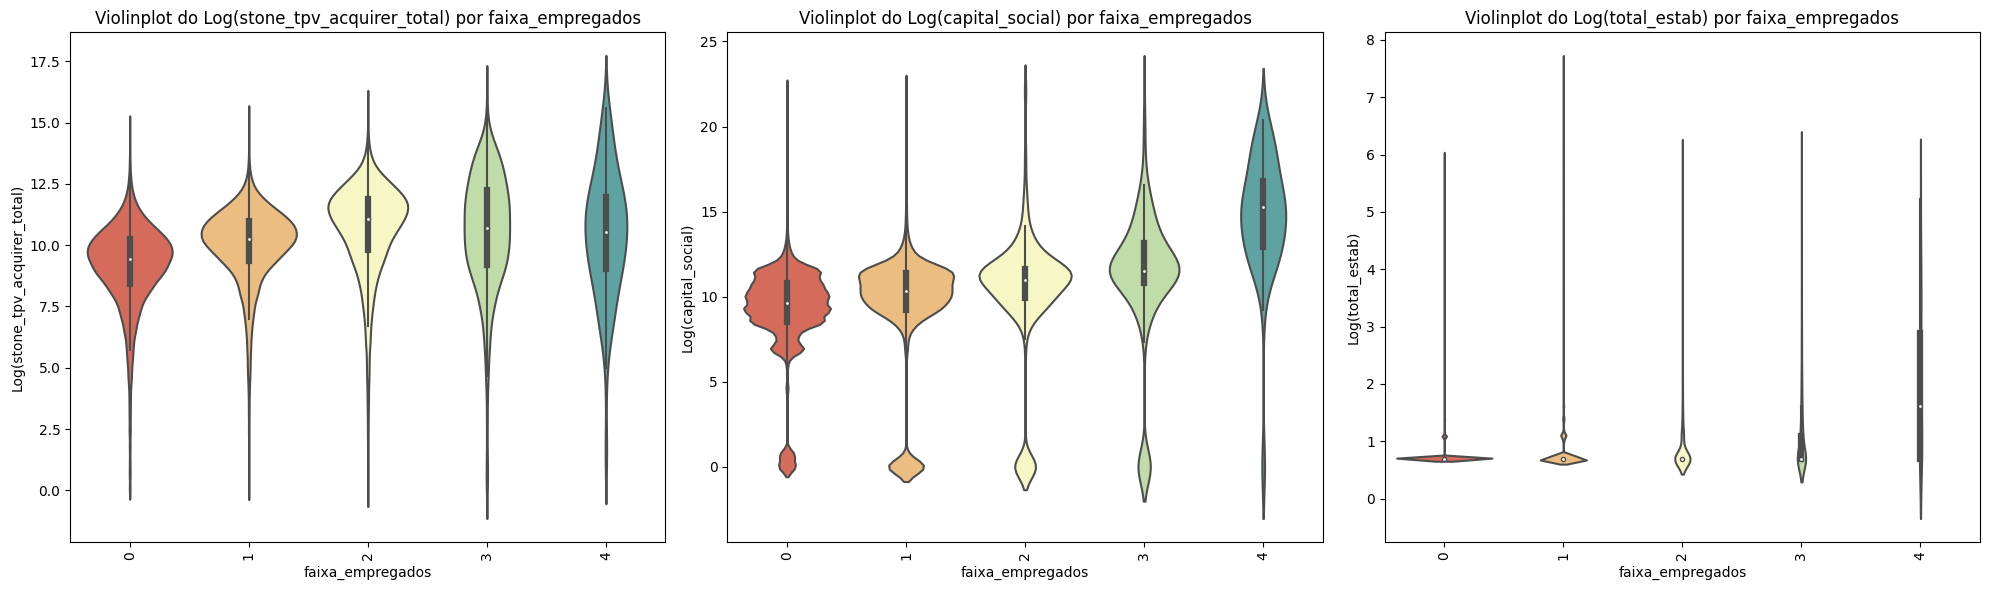

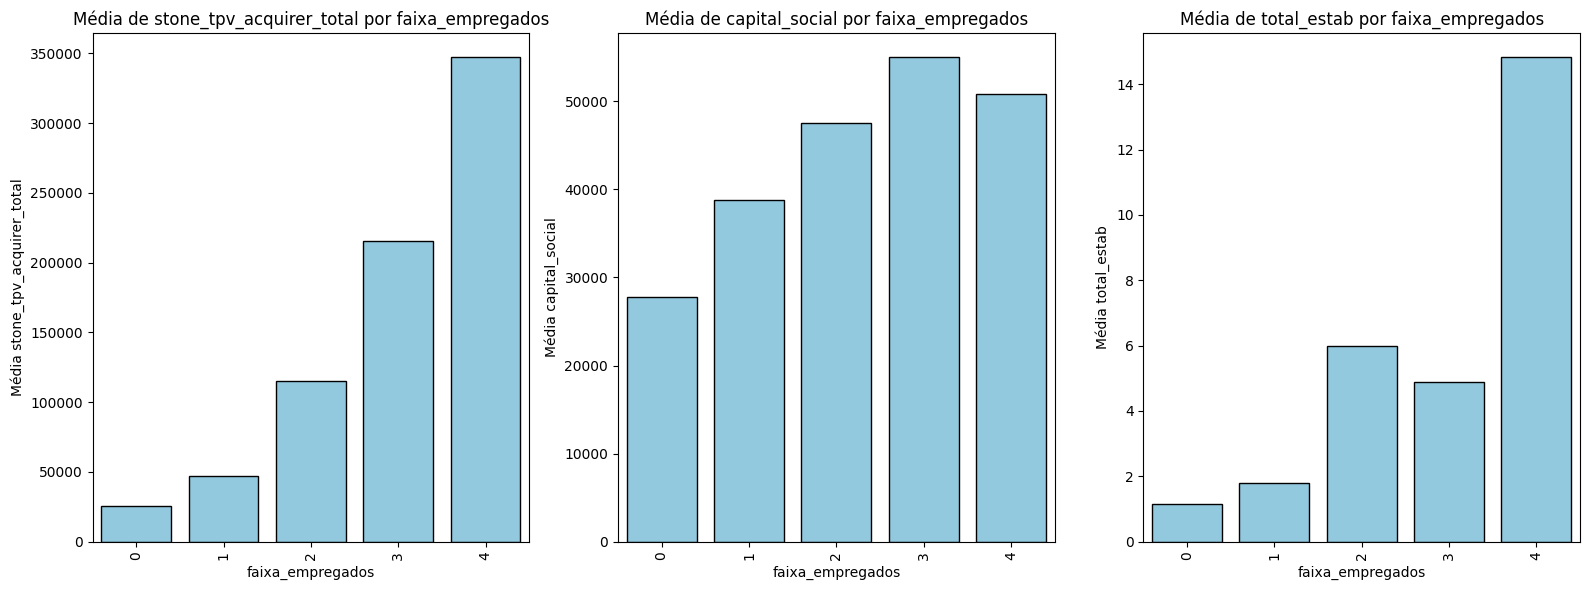

In [111]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'faixa_empregados')

* Os gráficos indicam que o valor **0** para **faixa_empregados** tende a estar em valores mais baixo das três variáveis numéricas
* Já os valores **3** e **4** de **faixa_empregados** aparecem mais dispersos em valores mais altos, enquanto **1** e **2** se disperçam numa região intermediária
* Inferimos a partir destas informações que a faixa de empregados esta ordenada de forma crescente, onde empresas com menos empregados se encontram em **0** enquanto empresas com vários empregados estão em **4**

**Conclusões**
* Há certa dependência entre a faixa de empregados e o porte da empresa, como era de se esperar
* Conseguimos identificar as categorias de porte como sendo decrescentes e as faixas de empregados como crescentes
* É visível que há relação entre a faixa de empregados e o porte no valor do TPV, o que indica que estas podem ser relevantes para o modelo

### 2.2.2 - Dados Geográficos

**Análise Univariada**

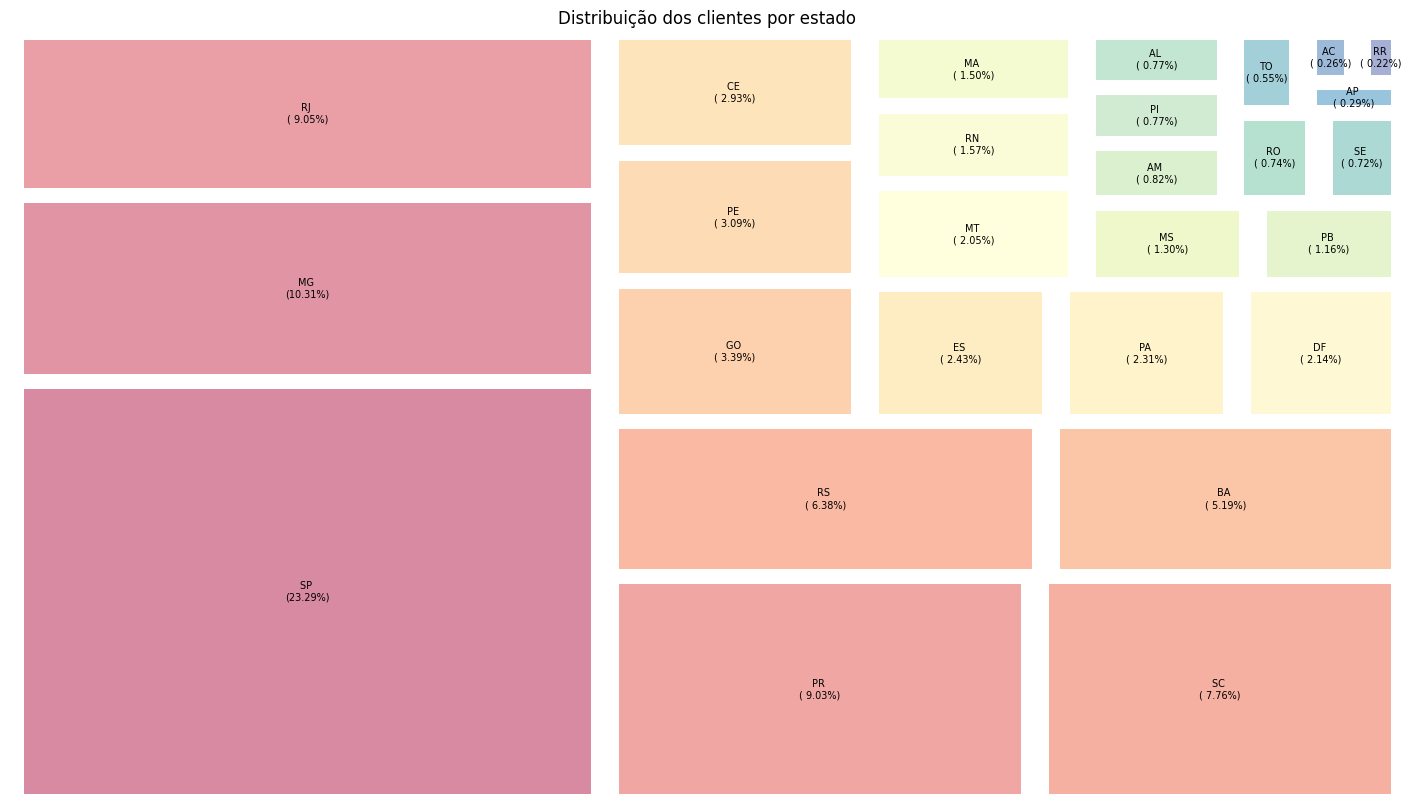

In [28]:
# Distribuição de clientes por estado
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)

tabela_estados = pd.DataFrame(df_tmp['uf'].value_counts()).reset_index().rename(columns = {'count':'contagem'})

perc = [str('{:5.2f}'.format(i/tabela_estados['contagem'].sum()*100)) + "%" for i in tabela_estados['contagem']]

rotulos = [f'{i[0]} \n({i[1]})' for i in zip(tabela_estados['uf'], perc)]

squarify.plot(sizes=tabela_estados['contagem'],label =rotulos,color = sns.color_palette('Spectral', len(tabela_estados['contagem'])), alpha=0.5,pad=1, text_kwargs={'fontsize':7},ax=ax )

plt.axis('off')

plt.title(f"Distribuição dos clientes por estado")

plt.show()

* Quase 70% dos clientes (68,25%) se concentram nas regiões Sul e Sudeste: 45,08% no Sudeste e 23,17% na região Sul.
* Iremos checar se os percentuais são proporcionais a distribuição demográfica da população no país

In [55]:
# Criação de uma coluna de região
def categorical_regiao(df): 
    conditions_regiao = [
                    df['uf'].isin(['PR','RS','SC']),
                    df['uf'].isin(['SP','MG','RJ','ES']),
                    df['uf'].isin(['MT','MS','GO','DF']),
                    df['uf'].isin(['AC','AM','RR','PA','AP','RO','TO']),
                    df['uf'].isin(['MA','PI','CE','RN','PB','PE','AL','SE','BA'])
                ] 
    choices_regiao = [
                        'Sul',
                        'Sudeste',
                        'Centro-Oeste',
                        'Norte',
                        'Nordeste'
                    ]

    return np.select(conditions_regiao, choices_regiao)

In [56]:
df_tmp['regiao'] = categorical_regiao(df_tmp)

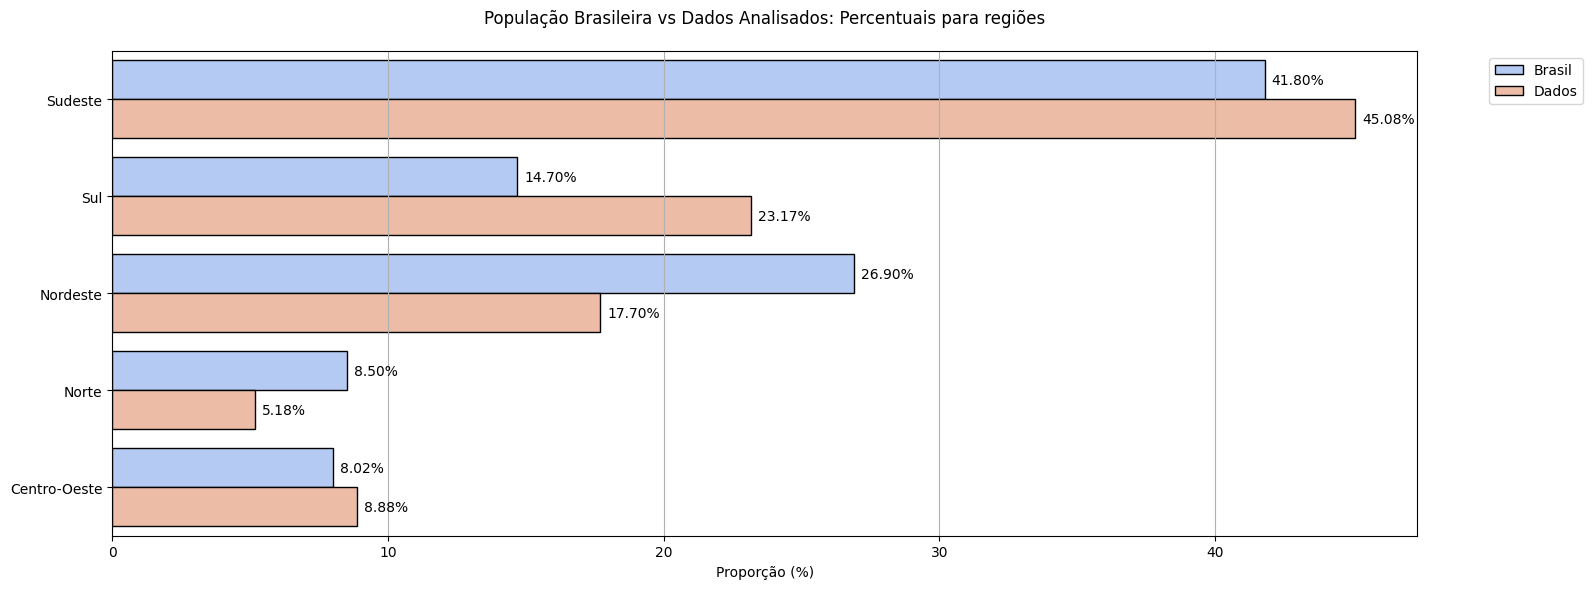

In [31]:
# Comparativo com a distribuição nacional

# Percentual populacional do país
# #https://noticias.uol.com.br/ultimas-noticias/agencia-brasil/2023/06/28/populacao-do-brasil-passa-de-203-milhoes-mostra-censo-2022.htm
norte_br= 8.5
sul_br =  14.7
sudeste_br = 41.8
centro_oeste_br=8.02
nordeste_br=26.9

regiao = {}
for nome in df_tmp.regiao.unique():
    regiao[nome] = round(df_tmp[df_tmp['regiao'] == nome].shape[0]*100/df_tmp.shape[0], 2)

data = {
    'Regiao': ['Sudeste', 'Sul', 'Nordeste', 'Norte', 'Centro-Oeste'],
    'Brasil': [sudeste_br, sul_br, nordeste_br, norte_br, centro_oeste_br],
    'Dados': [regiao['Sudeste'], regiao['Sul'], regiao['Nordeste'], regiao['Norte'], regiao['Centro-Oeste']]
}

df_plot = pd.DataFrame(data)

df_melt = df_plot.melt('Regiao', var_name='Tipo', value_name='Porcentagem')

plt.figure(figsize=(16, 6),tight_layout=True)
ax = sns.barplot(x='Porcentagem', y='Regiao', hue='Tipo', data=df_melt, palette='coolwarm', edgecolor='black')

for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}%', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                xytext=(5, 0), textcoords='offset points', ha='left', va='center')

plt.title('População Brasileira vs Dados Analisados: Percentuais para regiões', pad=20)
plt.xlabel('Proporção (%)')
plt.ylabel('')
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x')

plt.show()

* As regiões Nordeste e Norte estão subrepresentadas nos nossos dados (com 9.2% de diferença para o Nordeste)

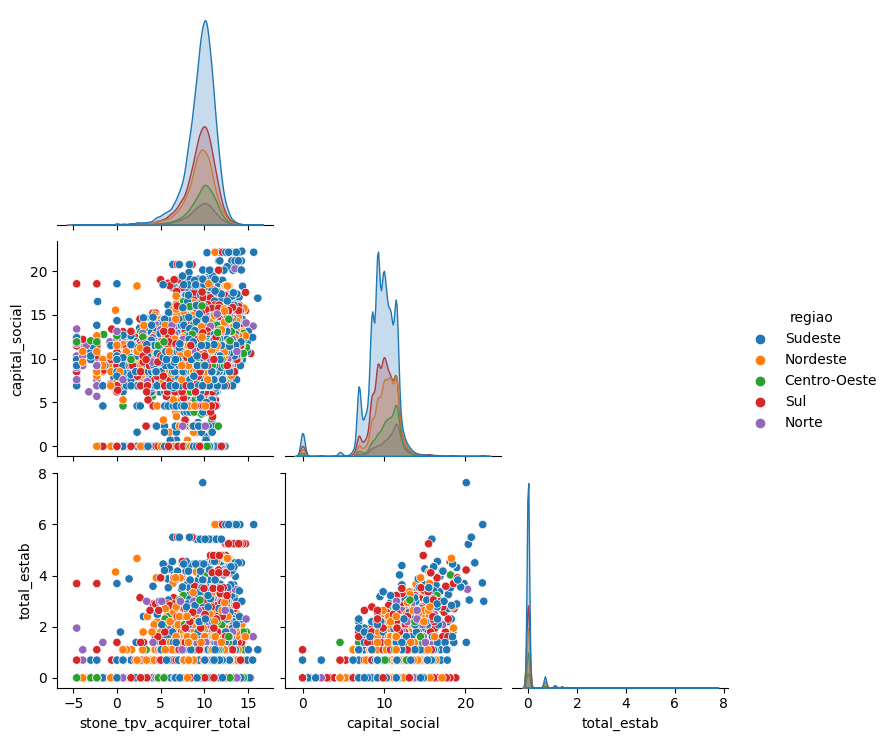

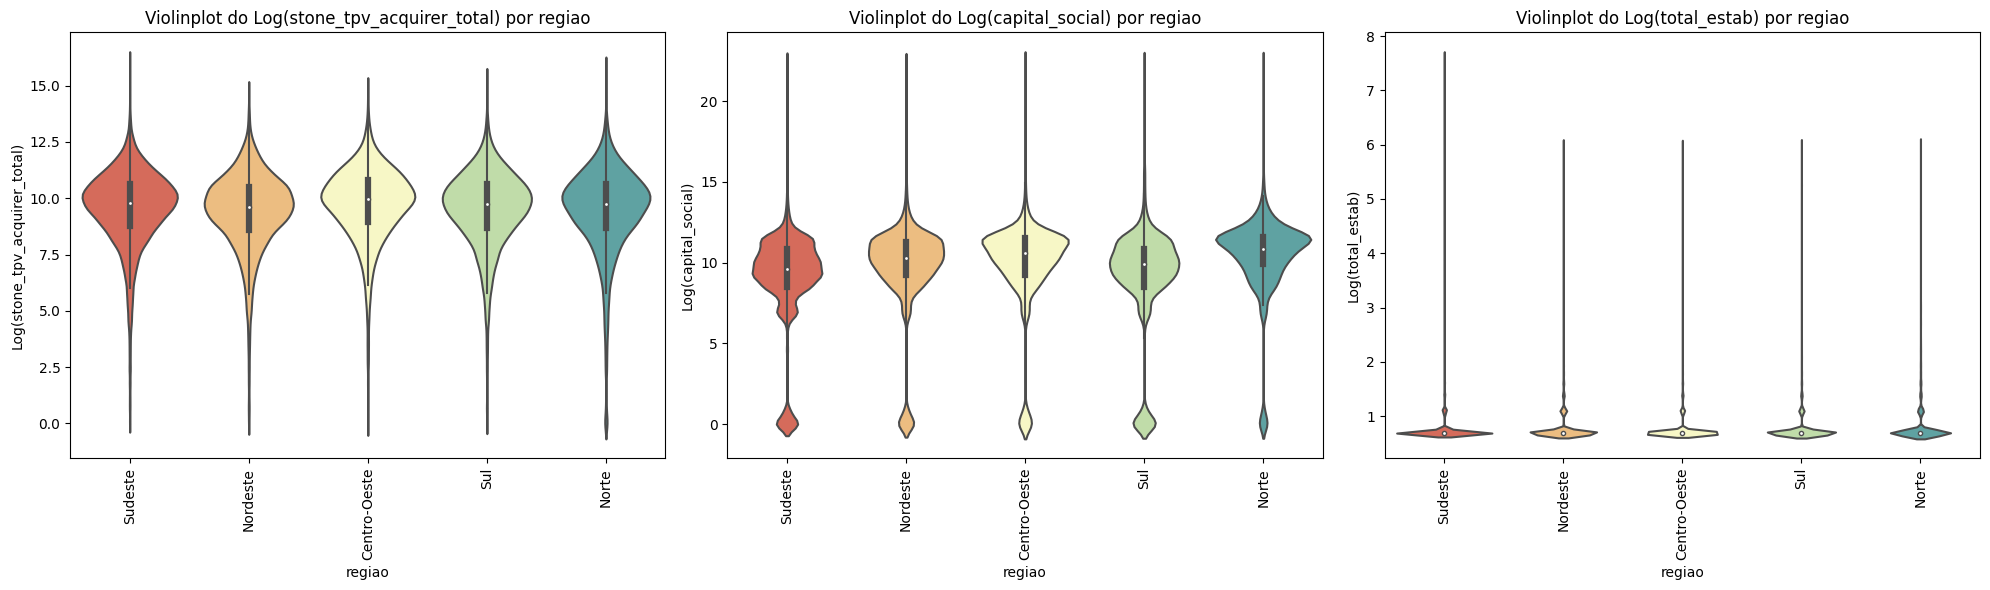

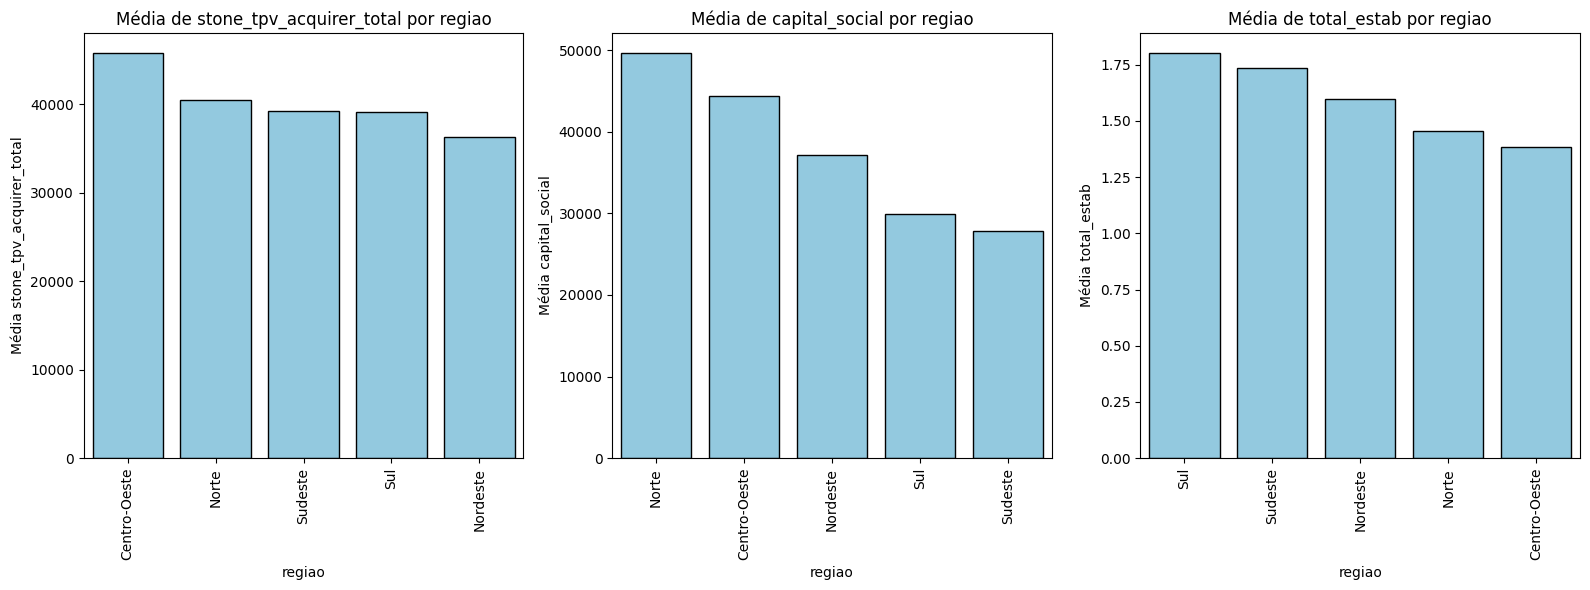

In [112]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'regiao')

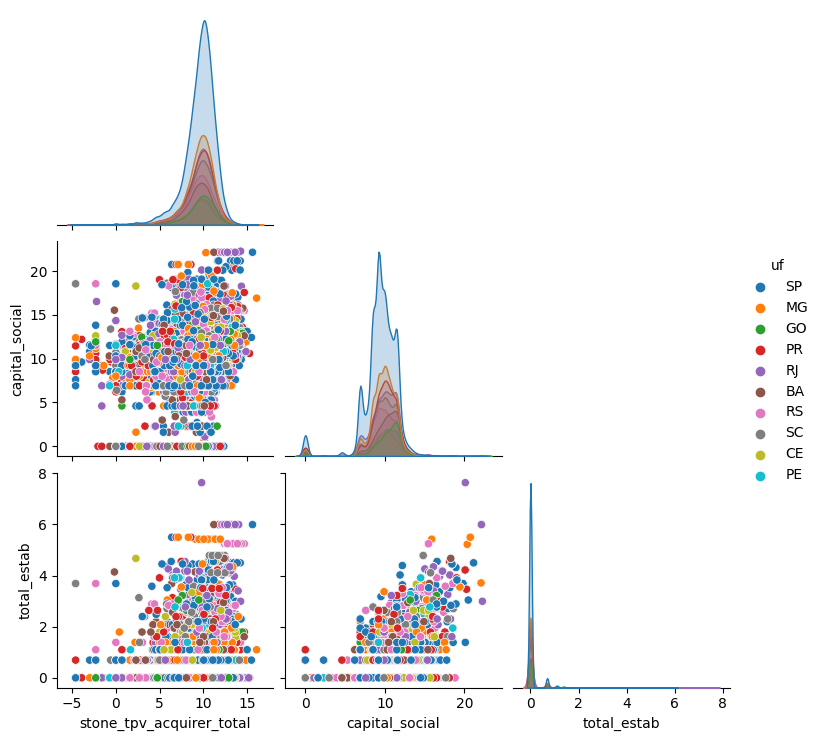

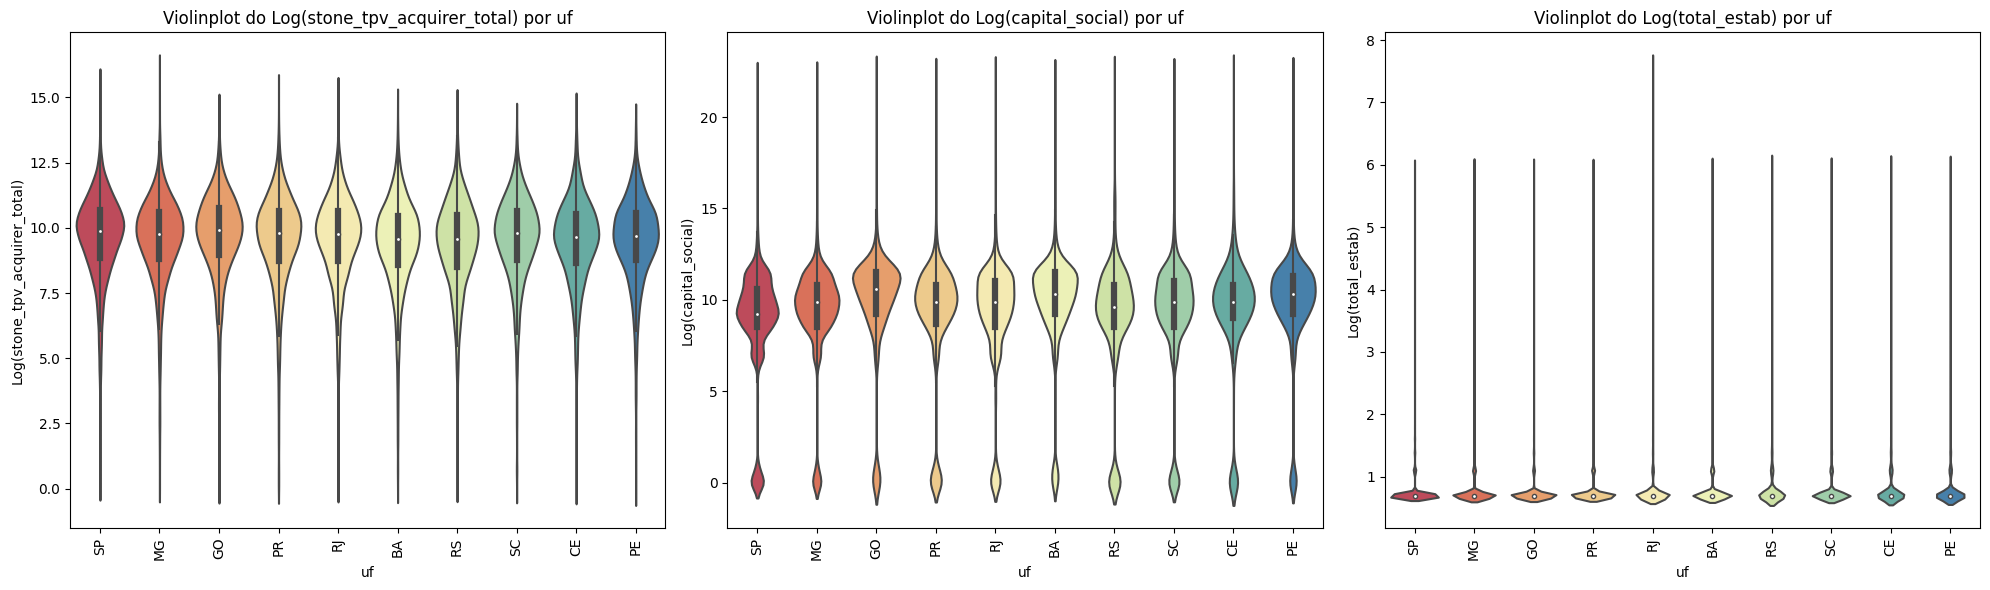

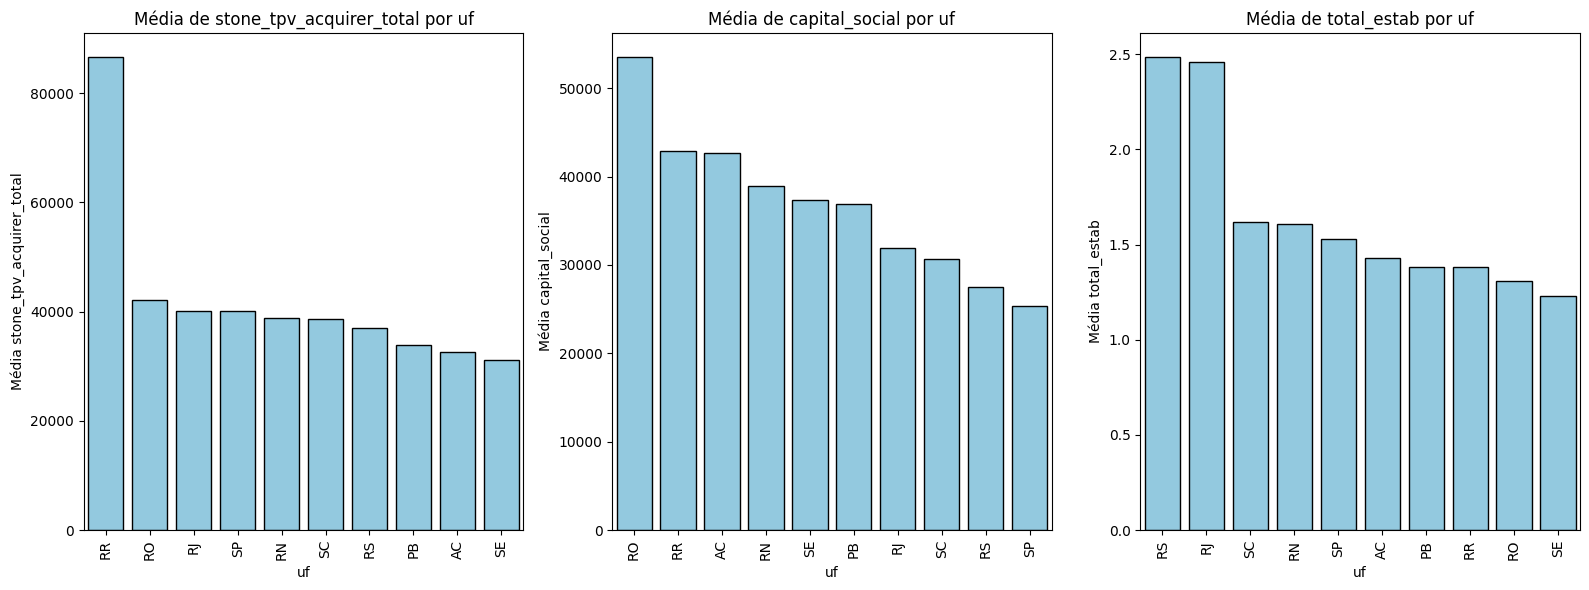

In [114]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'uf',10)

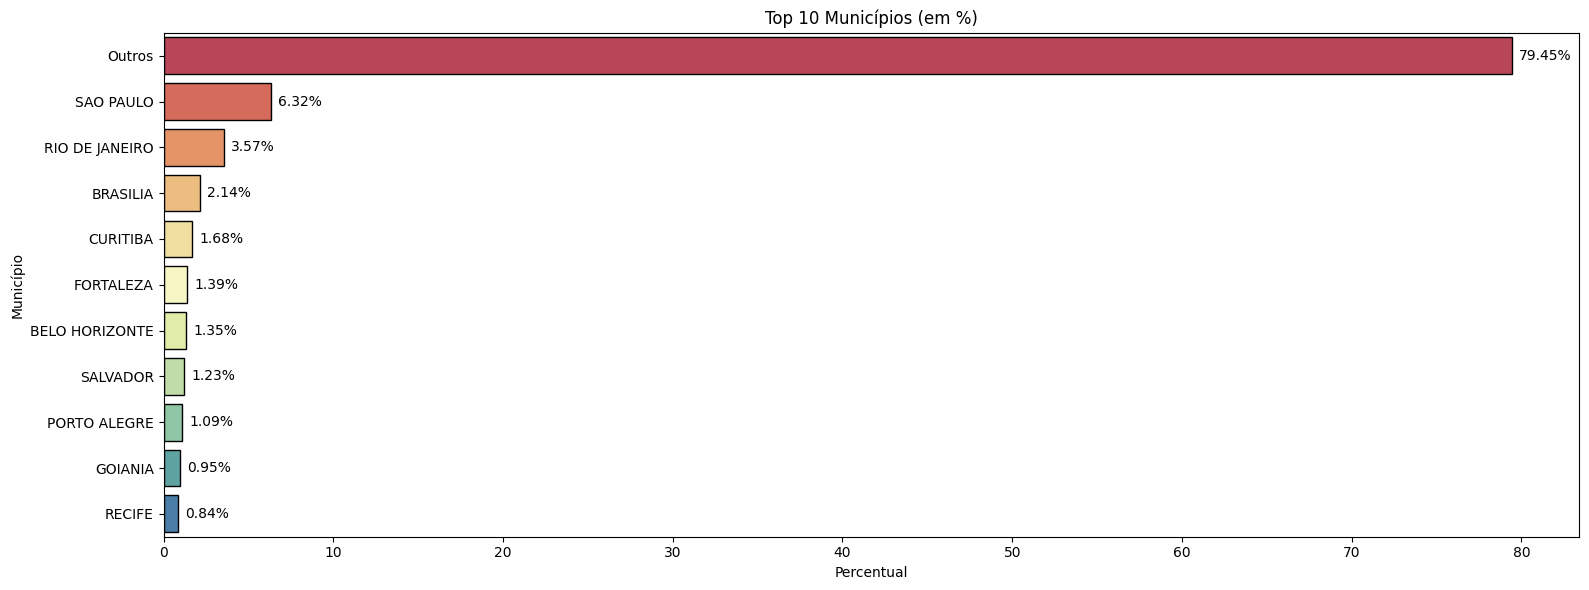

In [38]:
# Histograma dos top 10 municipios
top_municipios = df_tmp['municipio'].value_counts()
df_tmp['municipio_agrupado'] = df_tmp['municipio'].apply(lambda x: x if x in top_municipios.head(10) else 'Outros')

# Calcular os percentuais
total_municipios = len(df_tmp['municipio_agrupado'])
percentual_municipios = df_tmp['municipio_agrupado'].value_counts() / total_municipios * 100

plt.figure(figsize=(16, 6), tight_layout=True)
ax = sns.barplot(x=percentual_municipios.values, y=percentual_municipios.index, palette='Spectral', edgecolor='black')
plt.title('Top 10 Municípios (em %)')
plt.xlabel('Percentual')
plt.ylabel('Município')

for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}%', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                xytext=(5, 0), textcoords='offset points', ha='left', va='center')

plt.show()


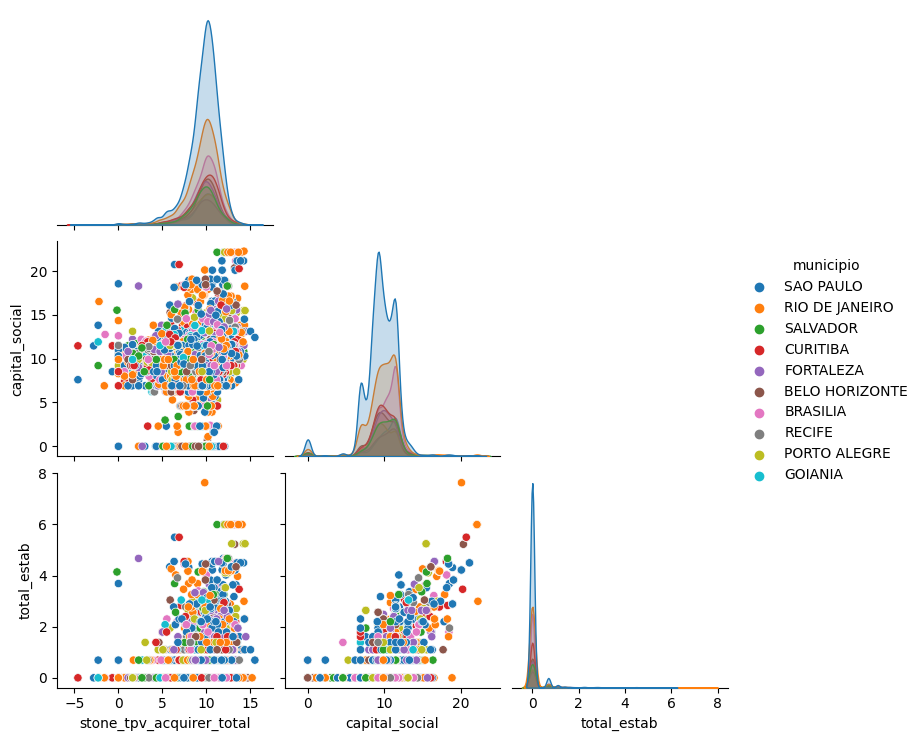

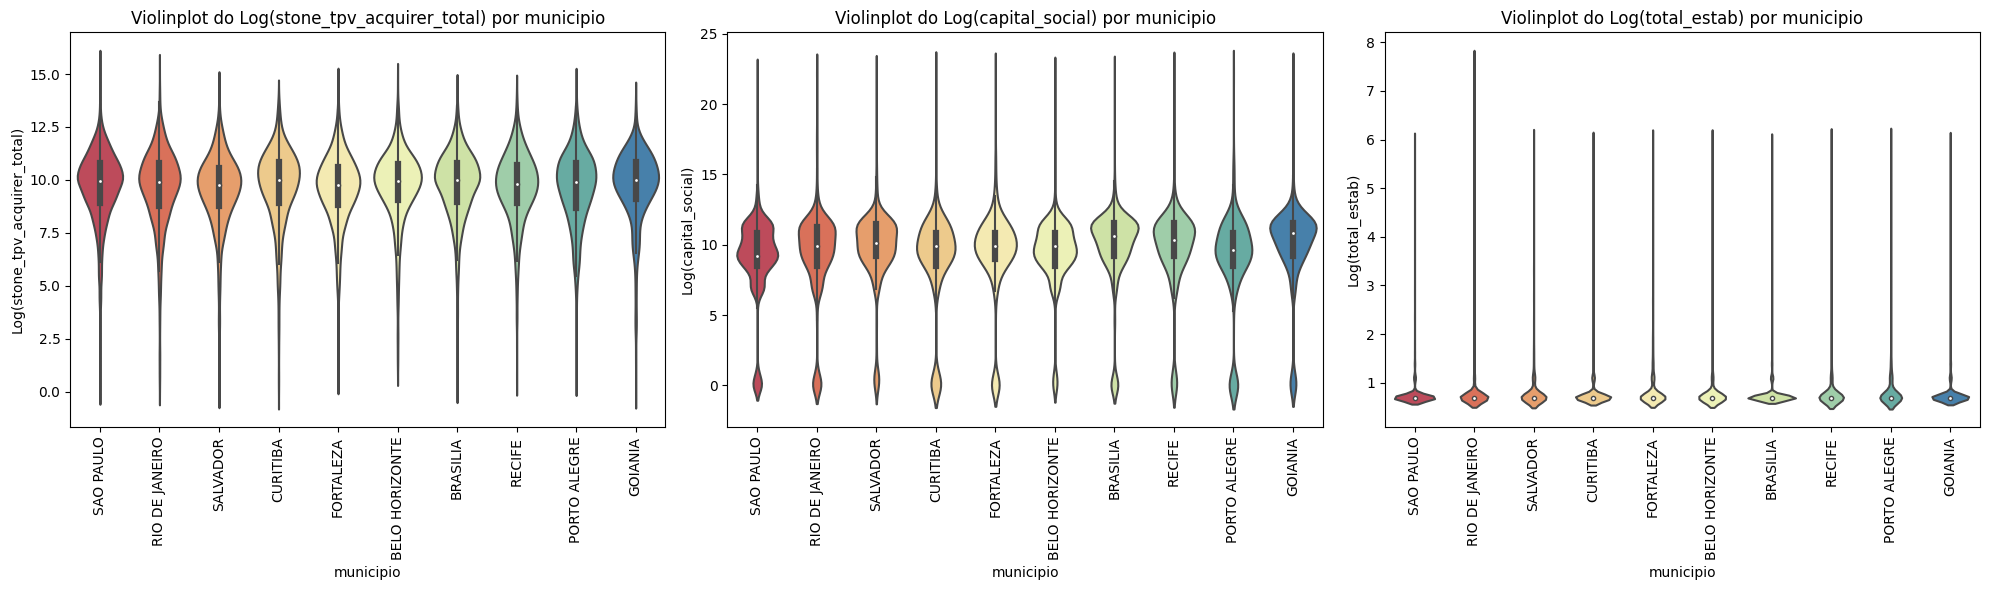

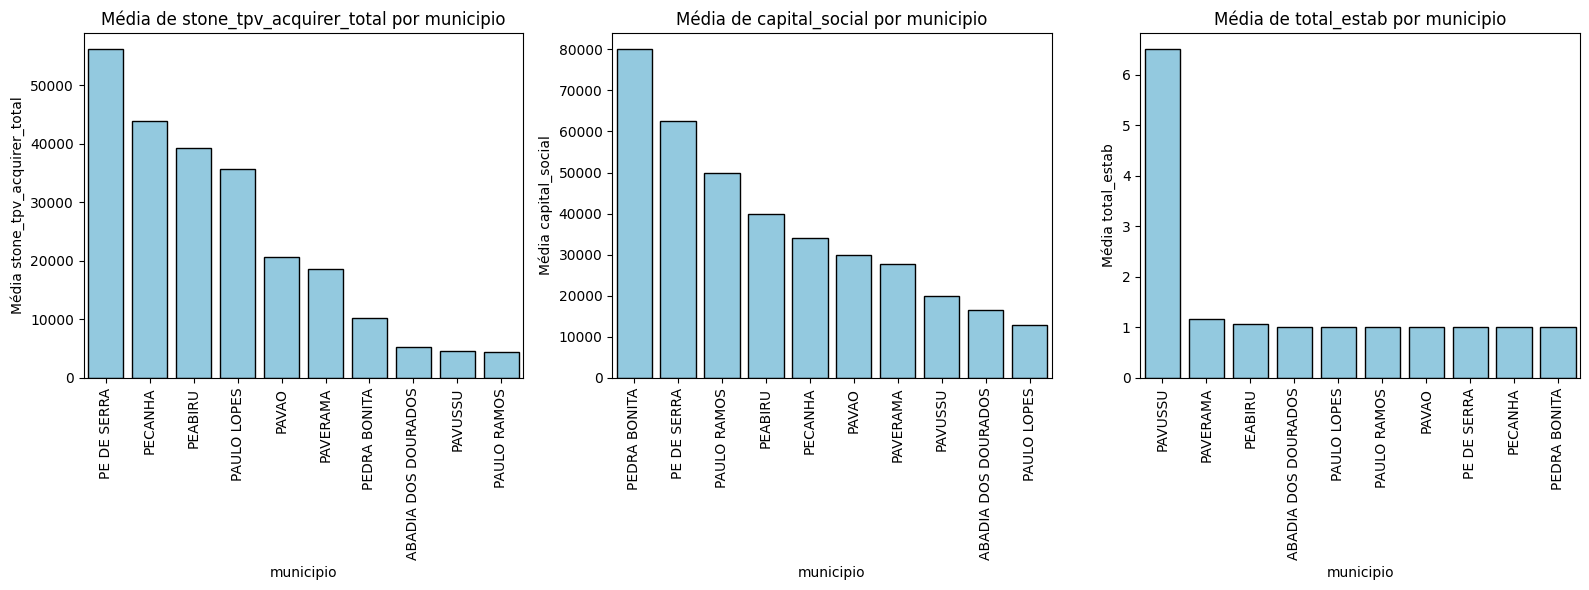

In [155]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'municipio',10)

* As 10 cidades com maior representação na nossa amostra são capitais, o que faz sentido visto que as capitais concentram grande número de lojistas

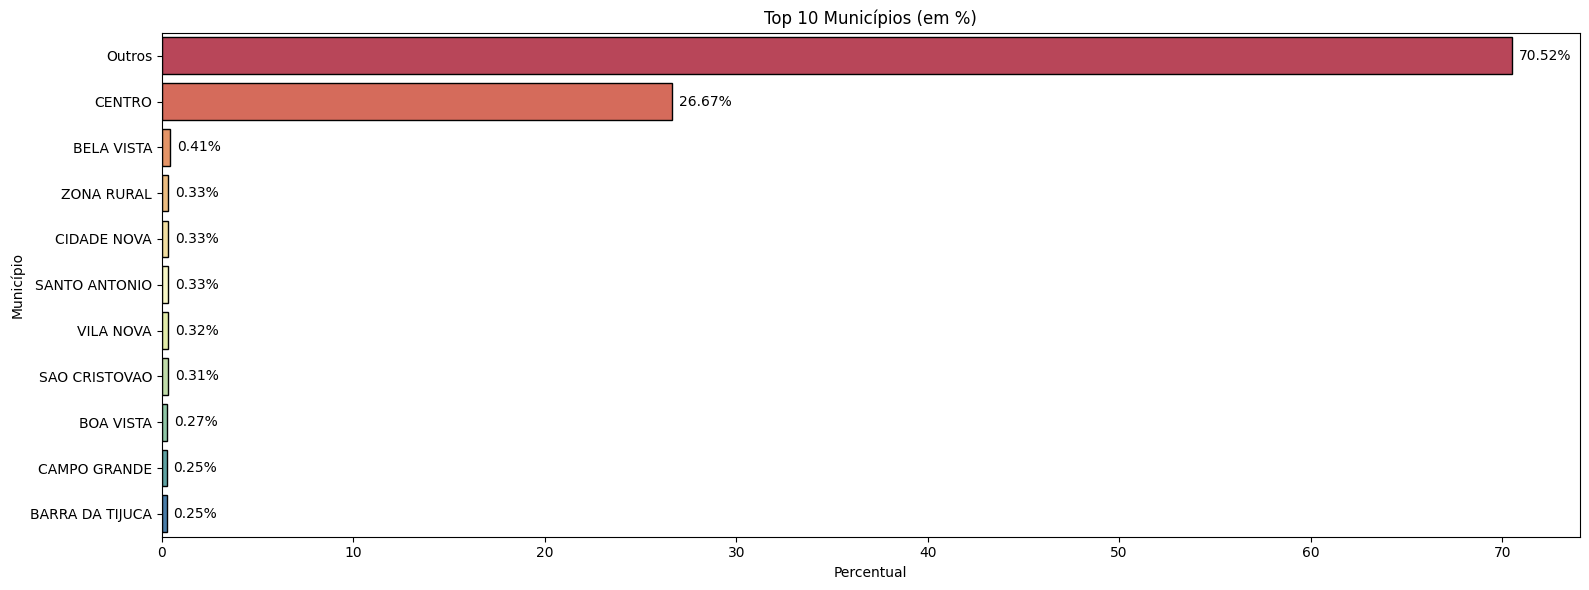

In [59]:
# Histograma dos top 10 bairros
top_bairros = df_tmp['bairro'].value_counts()
df_tmp['bairro_agrupado'] = df_tmp['bairro'].apply(lambda x: x if x in top_bairros.head(10) else 'Outros')

# Calcular os percentuais
total_bairros = len(df_tmp['bairro_agrupado'])
percentual_bairros = df_tmp['bairro_agrupado'].value_counts() / total_bairros * 100

plt.figure(figsize=(16, 6), tight_layout=True)
ax = sns.barplot(x=percentual_bairros.values, y=percentual_bairros.index, palette='Spectral', edgecolor='black')
plt.title('Top 10 Municípios (em %)')
plt.xlabel('Percentual')
plt.ylabel('Município')

for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}%', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                xytext=(5, 0), textcoords='offset points', ha='left', va='center')

plt.show()


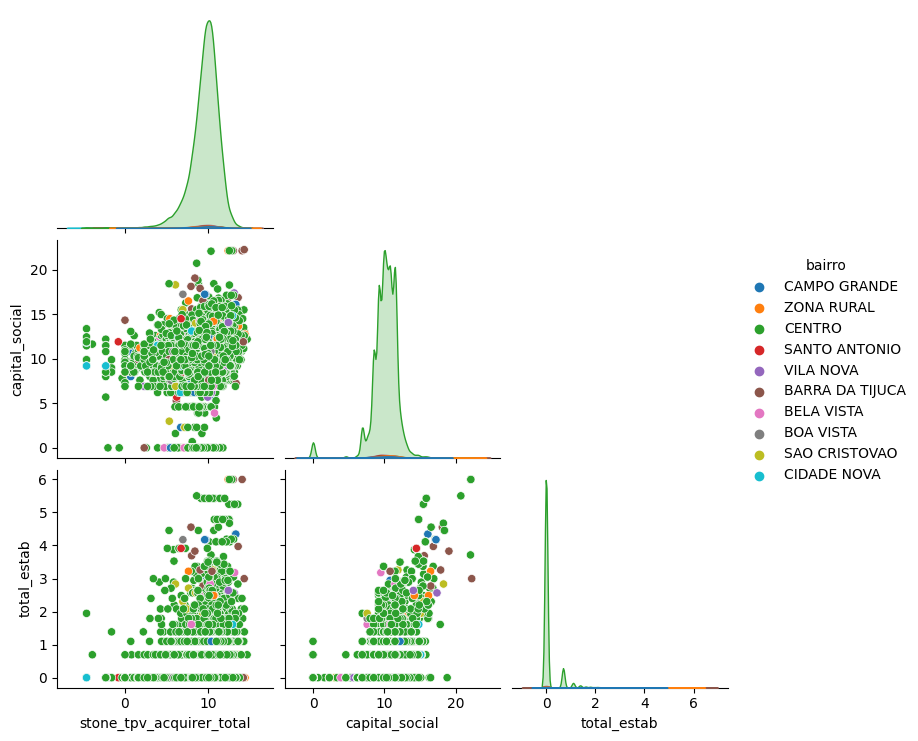

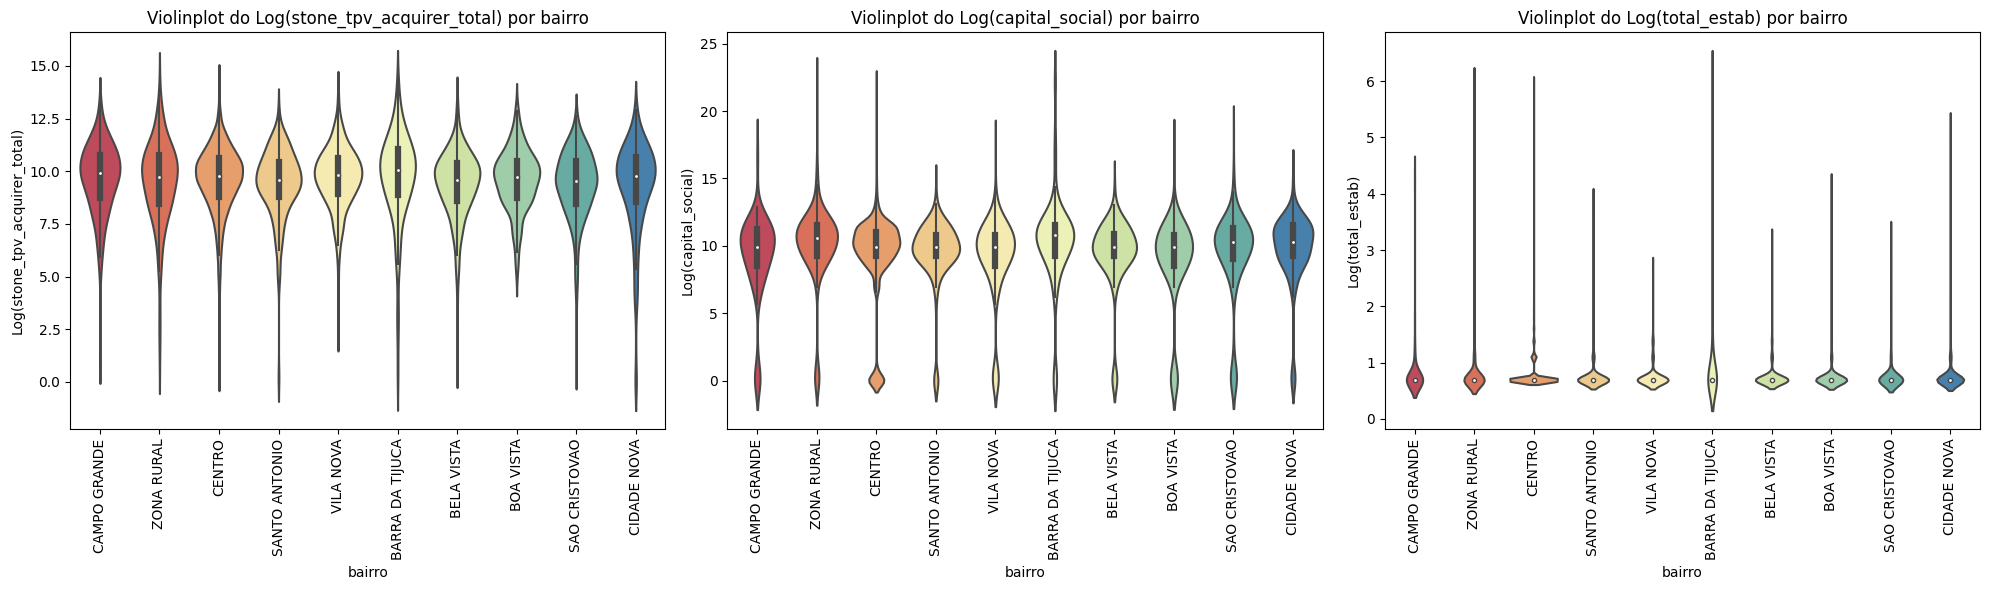

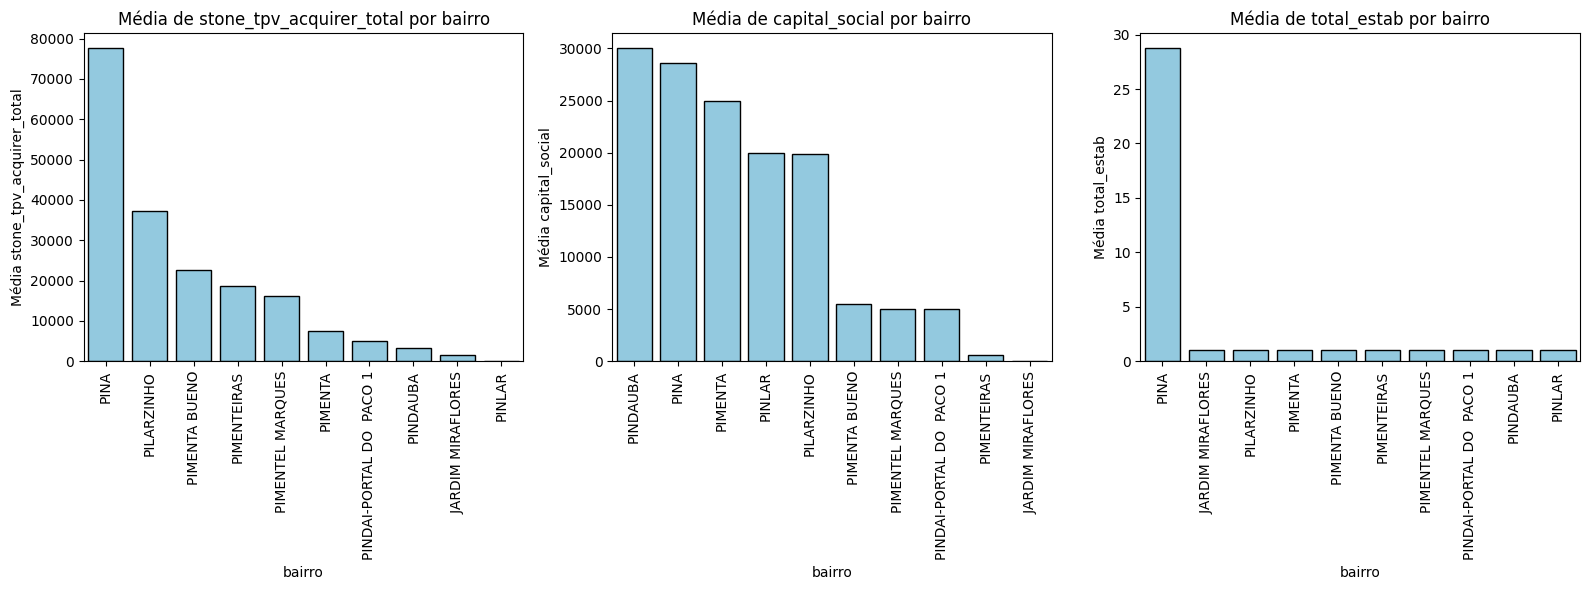

In [116]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'bairro',10)

Para tentarmos adquirir mais conhecimento a cerca da relação entre municipios e bairros com as variáveis numéricas vamos focar a análise em locais específicos:
* O Estado de São Paulo
* A cidade de São Paulo

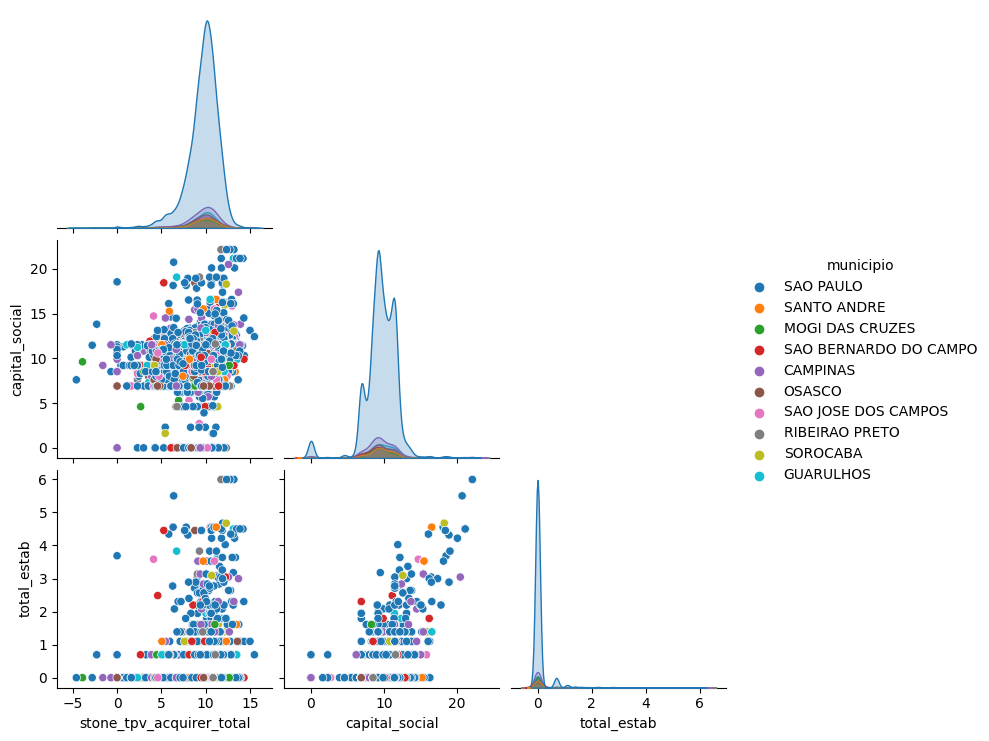

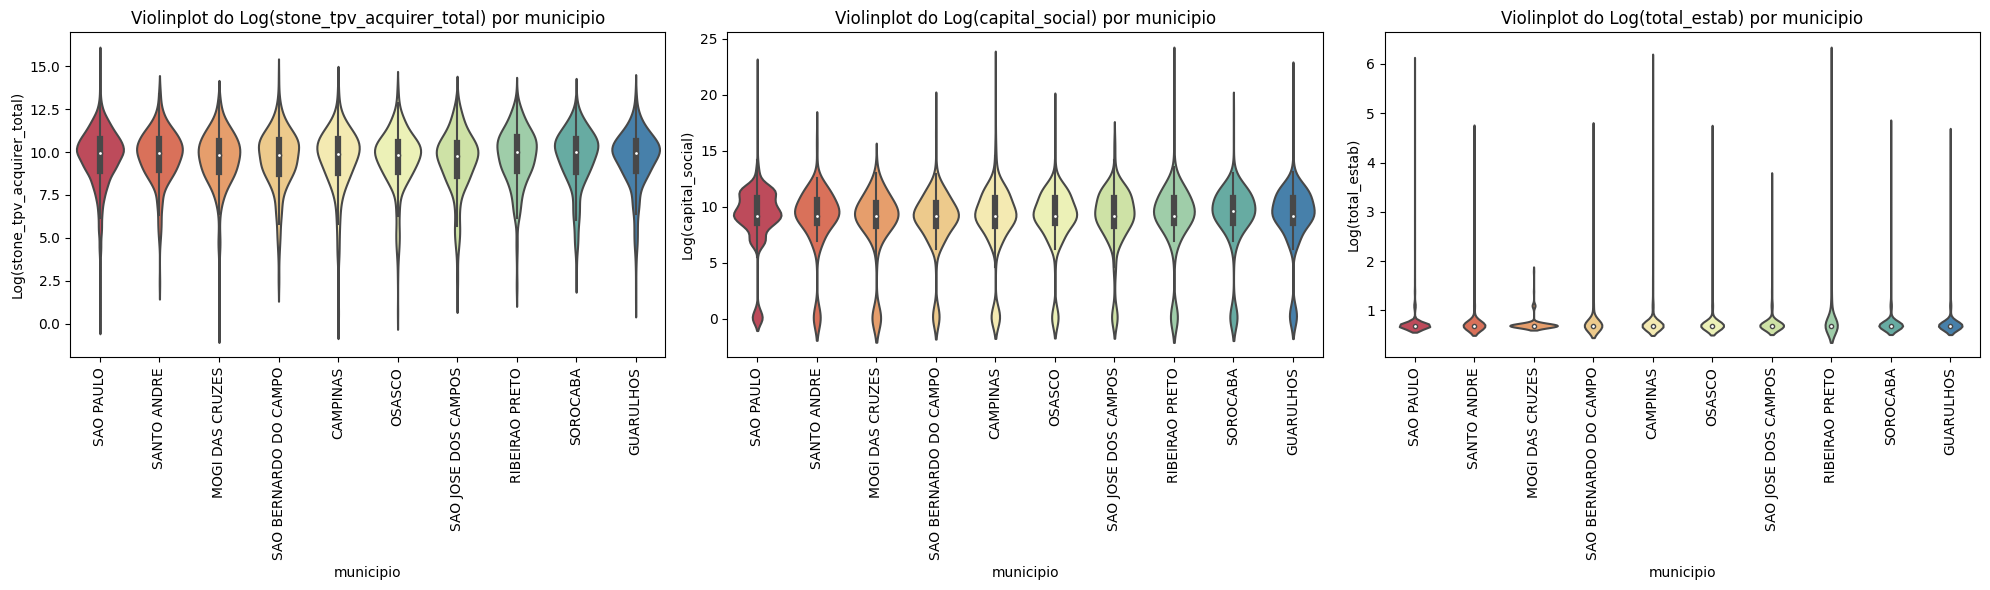

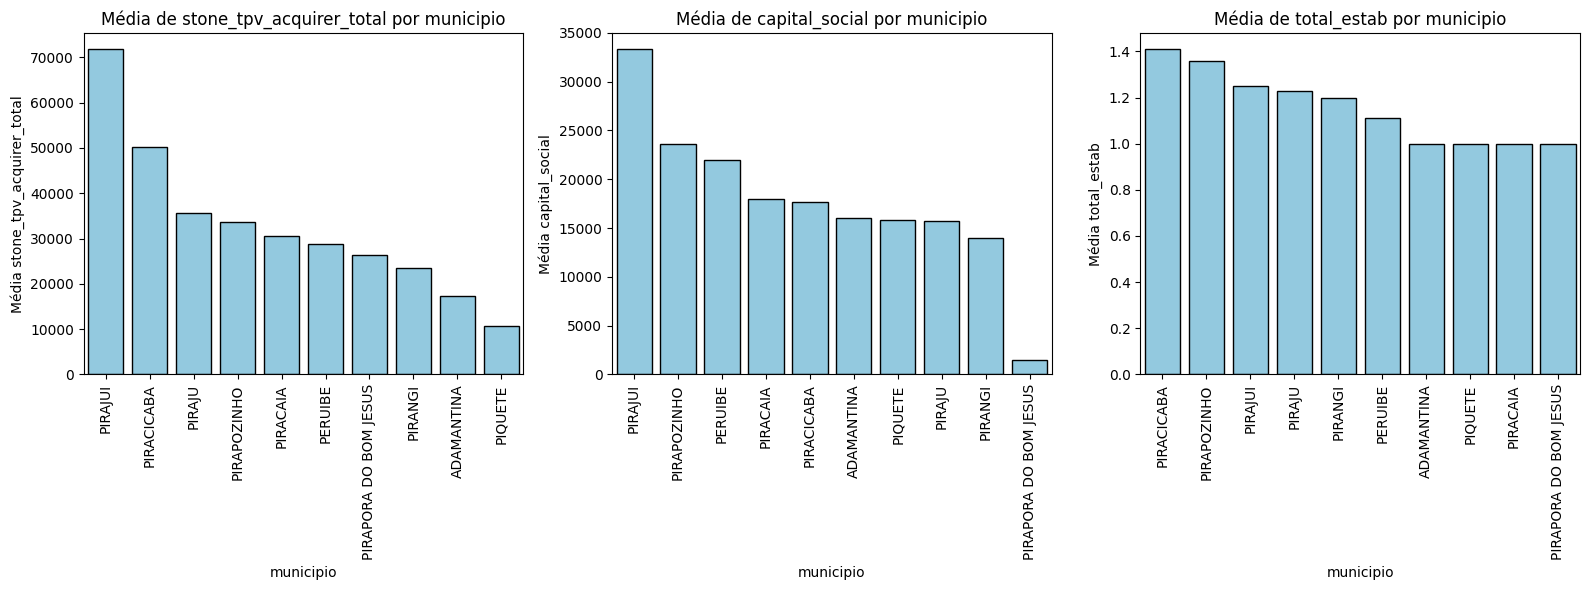

In [118]:
plot_combined(df_tmp[df_tmp['uf']=='SP'],['stone_tpv_acquirer_total','capital_social', 'total_estab'],'municipio',10)

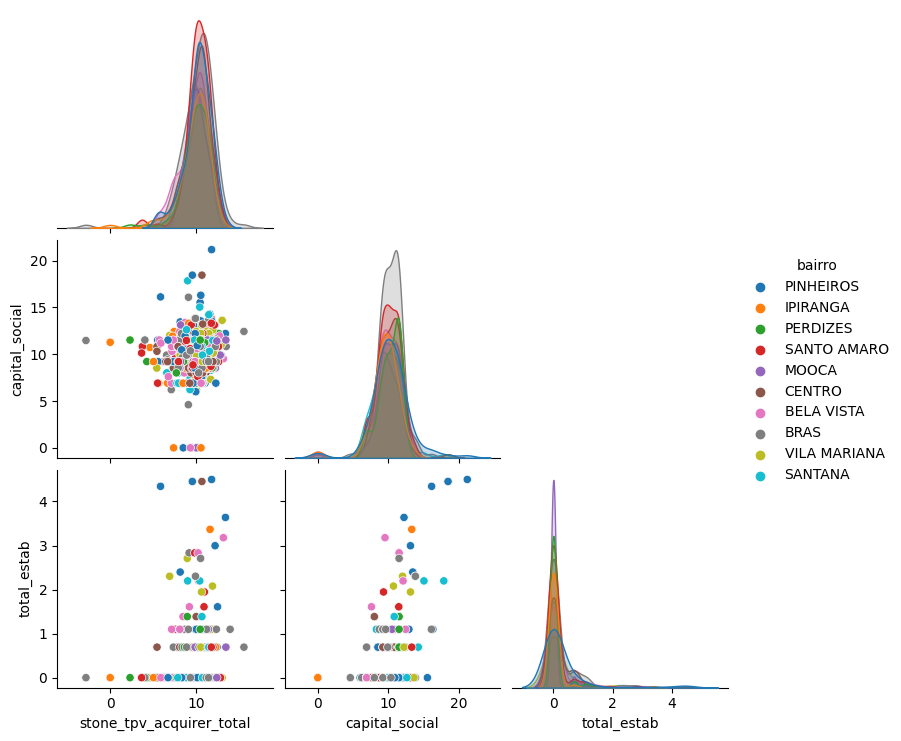

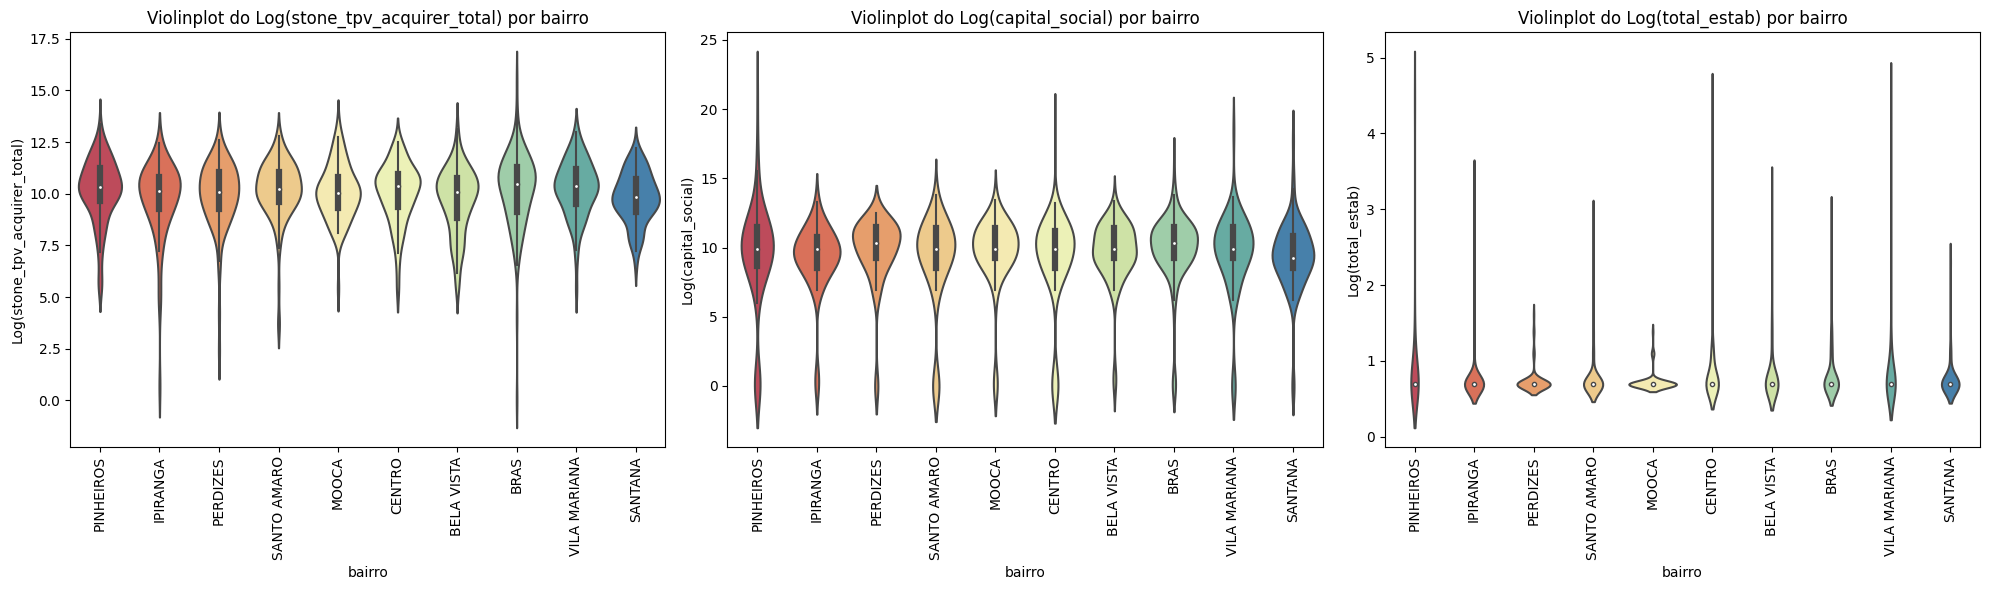

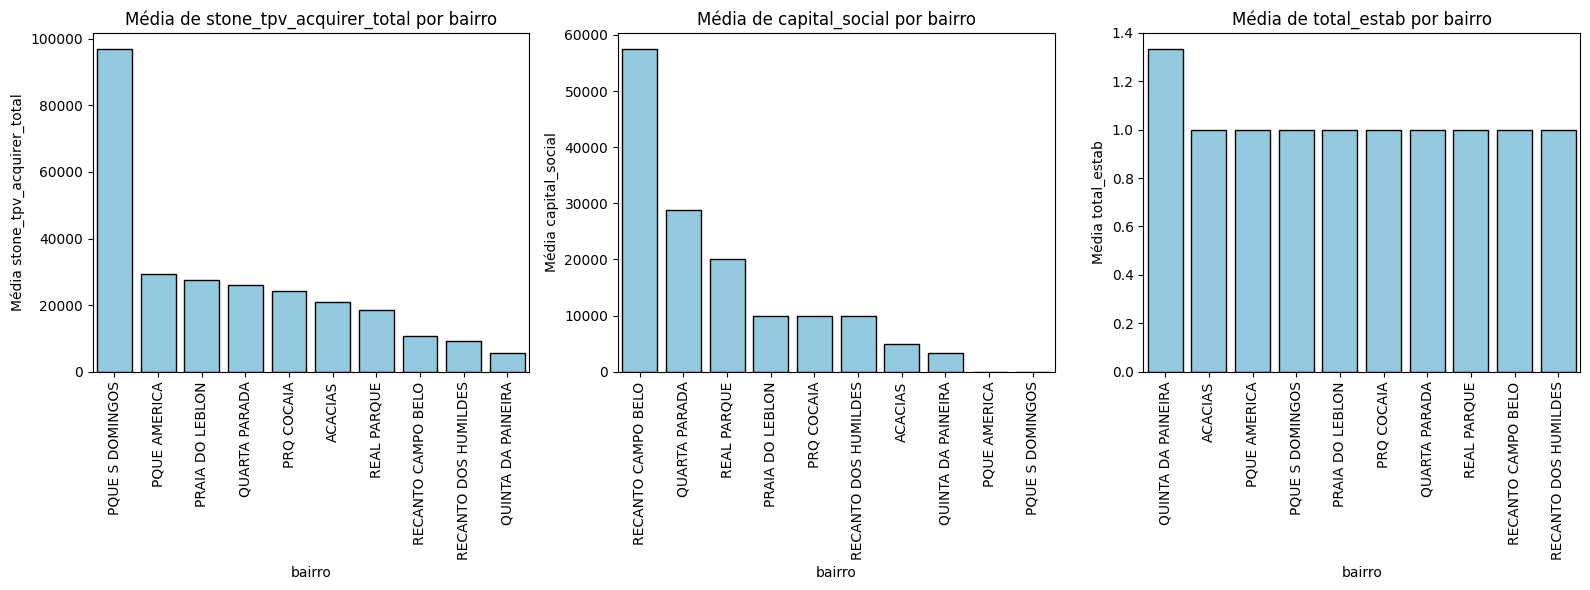

In [119]:
plot_combined(df_tmp[df_tmp['municipio']=='SAO PAULO'],['stone_tpv_acquirer_total','capital_social', 'total_estab'],'bairro',10)

**Conclusão**
* A maior concentração de clientes são nas regiões Sul e Sudeste do país, sendo o estado de São Paulo o líder em número de clientes
* Com relação a municípios, os clientes geralmente se concentram nas capitais e cidades próximas
* Bairros centrais ou focados em comércio são os mais presentes e com TPV alta
* Além das capitais, grandes municipios no interior dos estados, onde há atividade agropecuária, parecem ter TPV alta

### 2.2.3 - Dados Mercadológicos

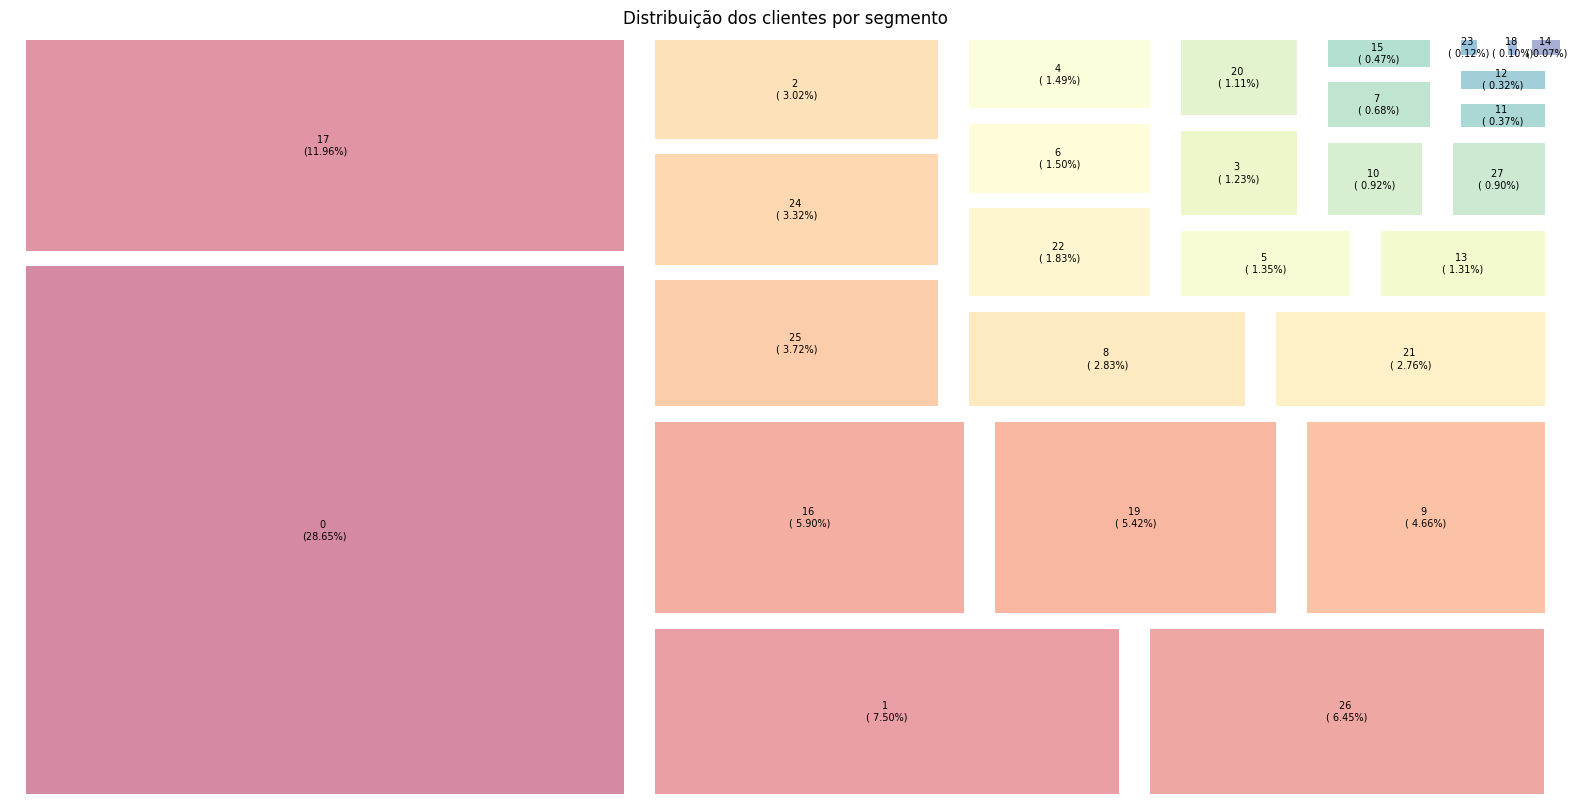

In [251]:
# Distribuição dos segmentos dos clientes

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

tabela_segmento = pd.DataFrame(df['segmento'].value_counts()).reset_index().rename(columns = {'count':'contagem'})

perc = [str('{:5.2f}'.format(i/tabela_segmento['contagem'].sum()*100)) + "%" for i in tabela_segmento['contagem']]

rotulos = [f'{i[0]} \n({i[1]})' for i in zip(tabela_segmento['segmento'], perc)]

squarify.plot(sizes=tabela_segmento['contagem'],label =rotulos,color = sns.color_palette('Spectral', len(tabela_segmento['contagem'])), alpha=0.5,pad=1, text_kwargs={'fontsize':7},ax=ax )

plt.axis('off')

plt.title(f"Distribuição dos clientes por segmento")

plt.show()

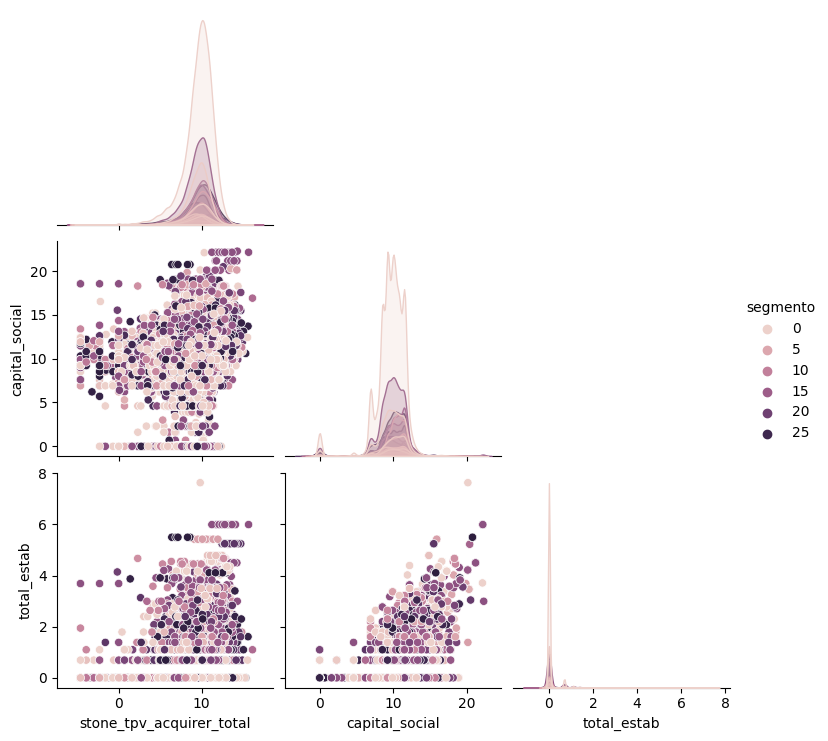

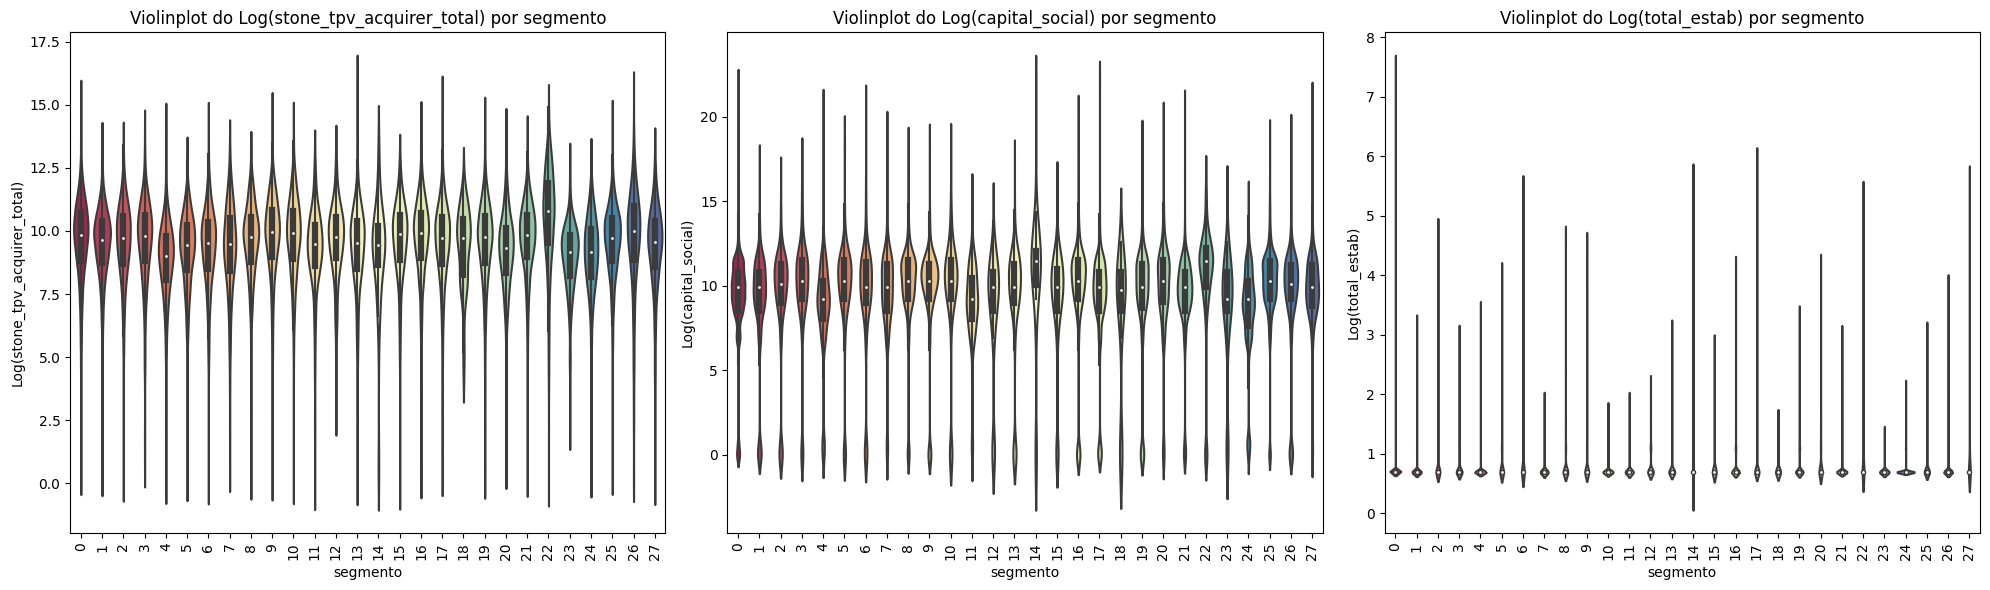

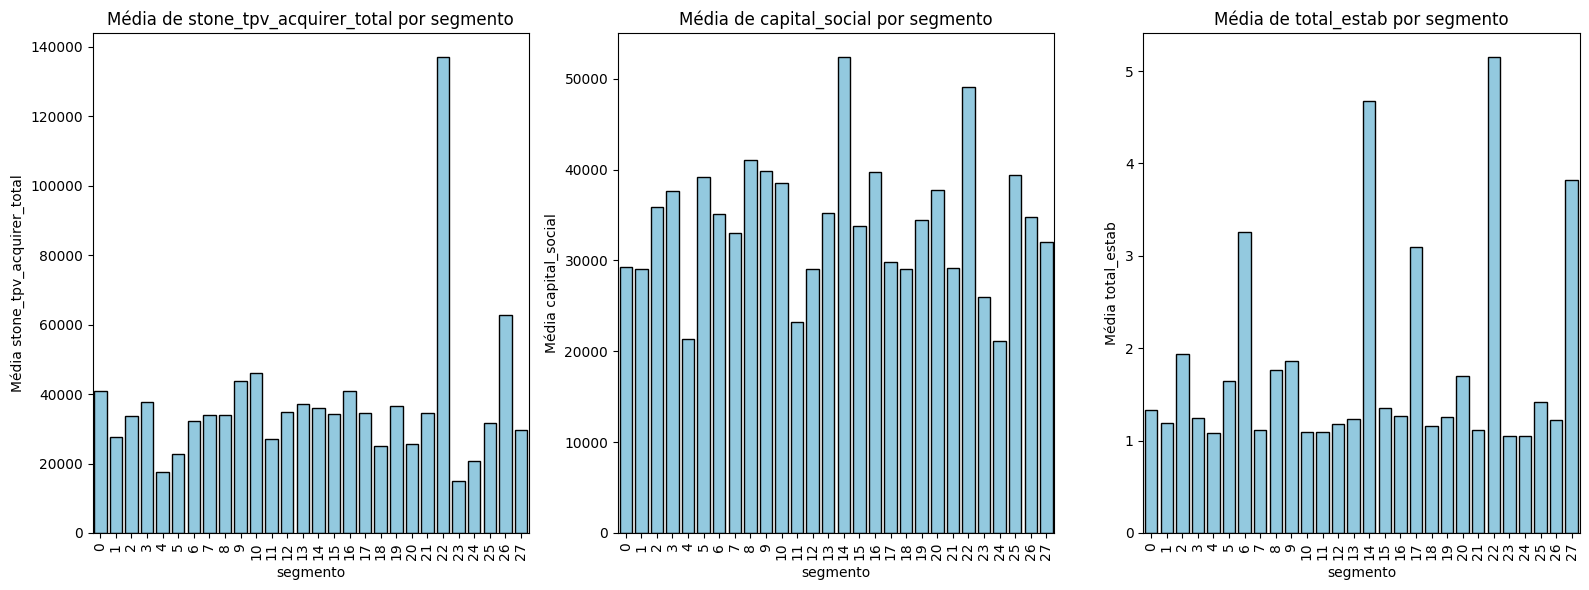

In [151]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'segmento')

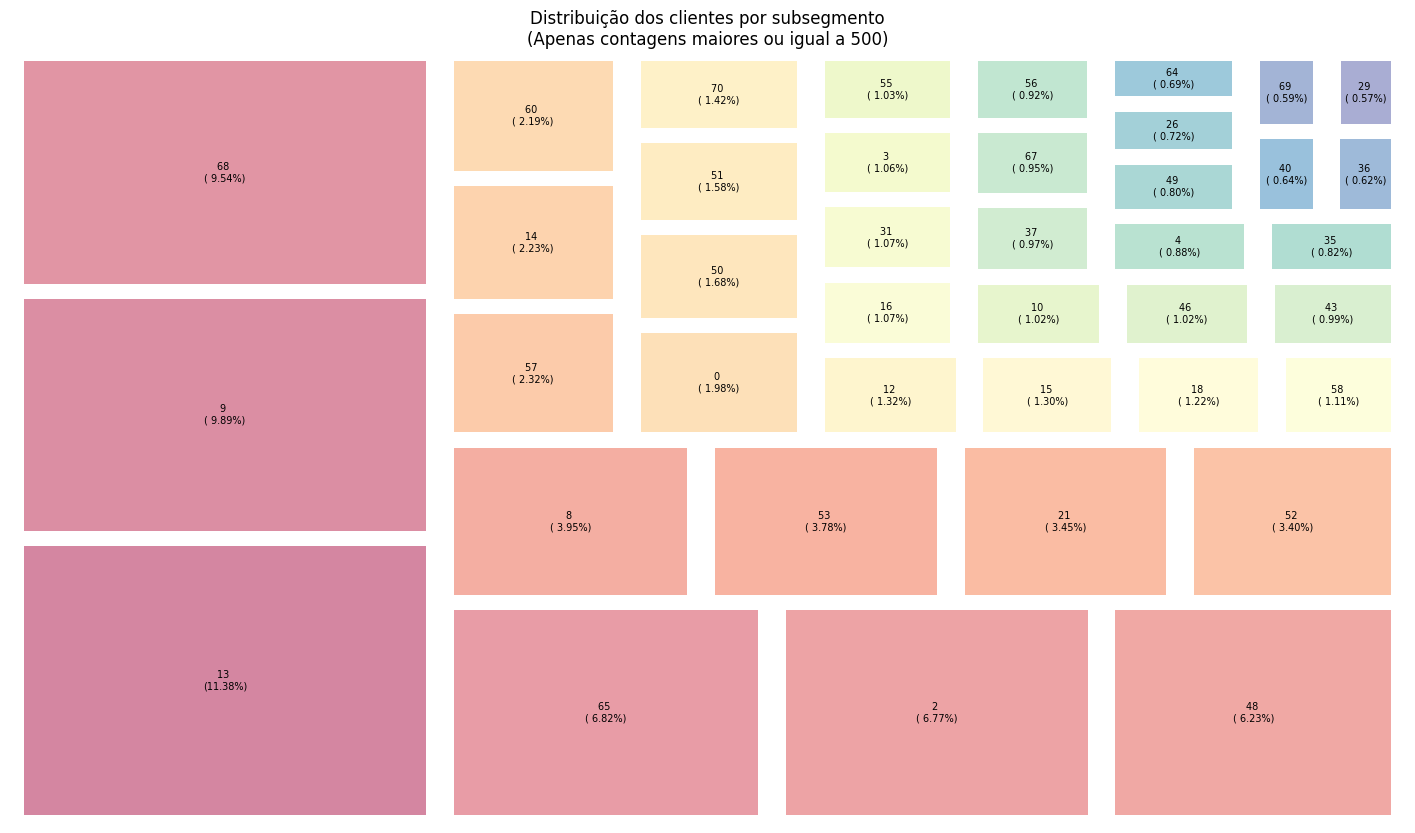

In [252]:
# Distribuição dos subsgmentos
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)

tabela_subsegmento = pd.DataFrame(df['subsegmento'].value_counts()).reset_index().rename(columns = {'count':'contagem'})

filtered_tabela_subsegmento = tabela_subsegmento[tabela_subsegmento['contagem'] >= 500]

perc = [str('{:5.2f}'.format(i / filtered_tabela_subsegmento['contagem'].sum() * 100)) + "%" for i in filtered_tabela_subsegmento['contagem']]

rotulos = [f'{i[0]} \n({i[1]})' for i in zip(filtered_tabela_subsegmento['subsegmento'], perc)]

squarify.plot(sizes=filtered_tabela_subsegmento['contagem'], label=rotulos, color=sns.color_palette('Spectral', len(filtered_tabela_subsegmento['contagem'])), alpha=0.5, pad=1, text_kwargs={'fontsize': 7}, ax=ax)

plt.axis('off')
plt.title(f"Distribuição dos clientes por subsegmento\n(Apenas contagens maiores ou igual a 500)")
plt.show()

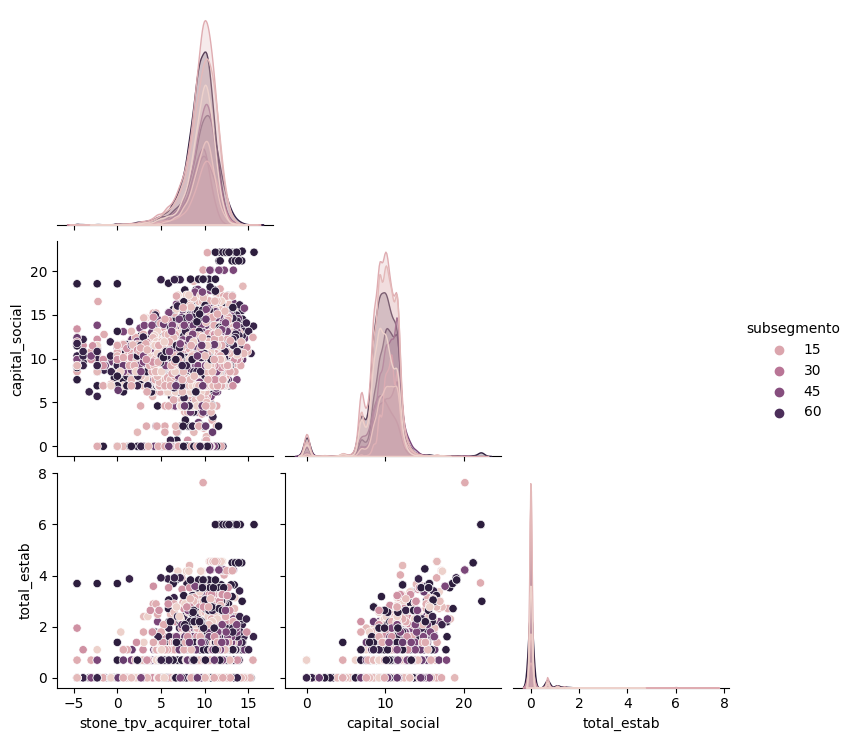

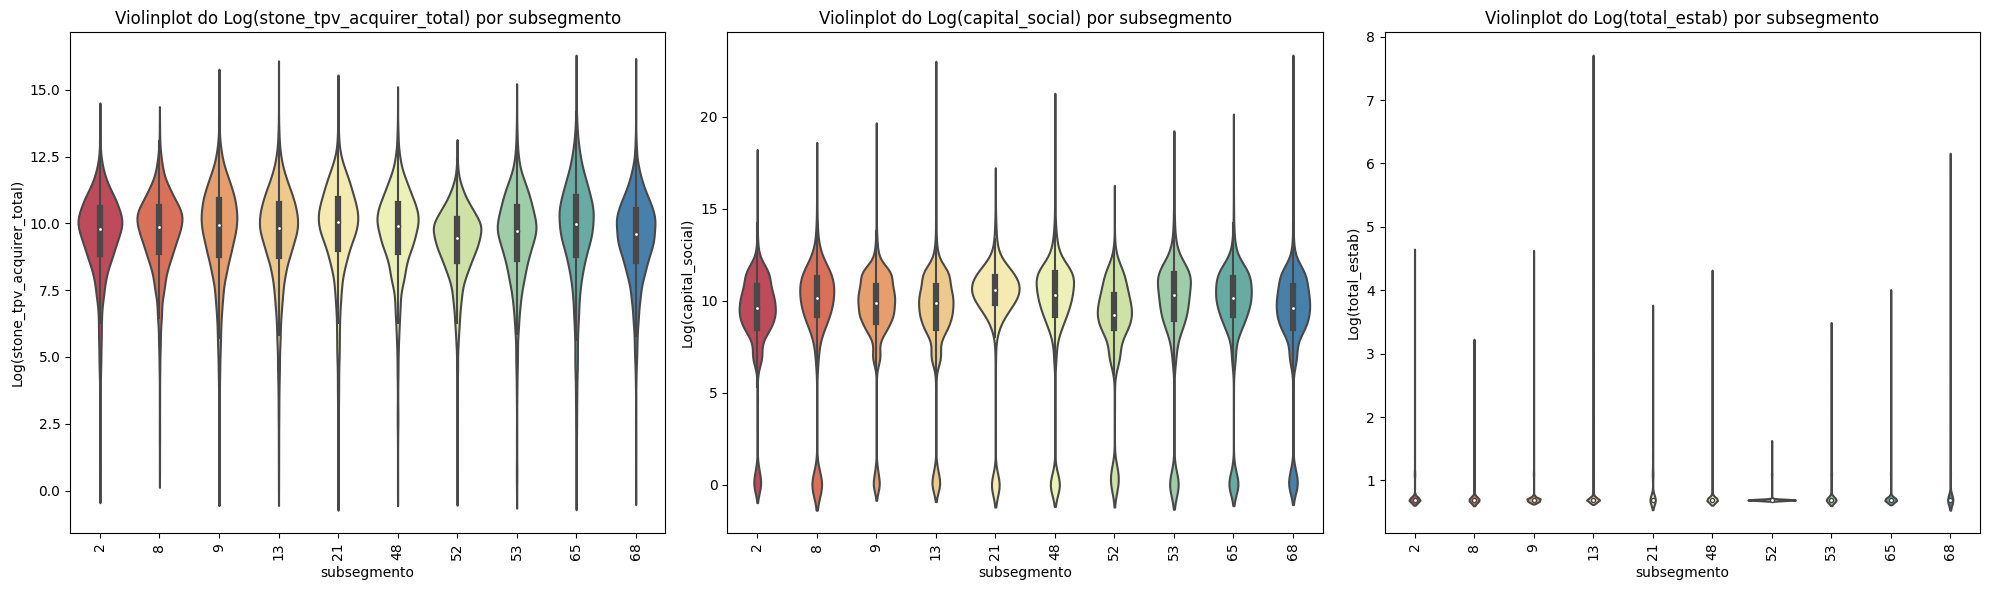

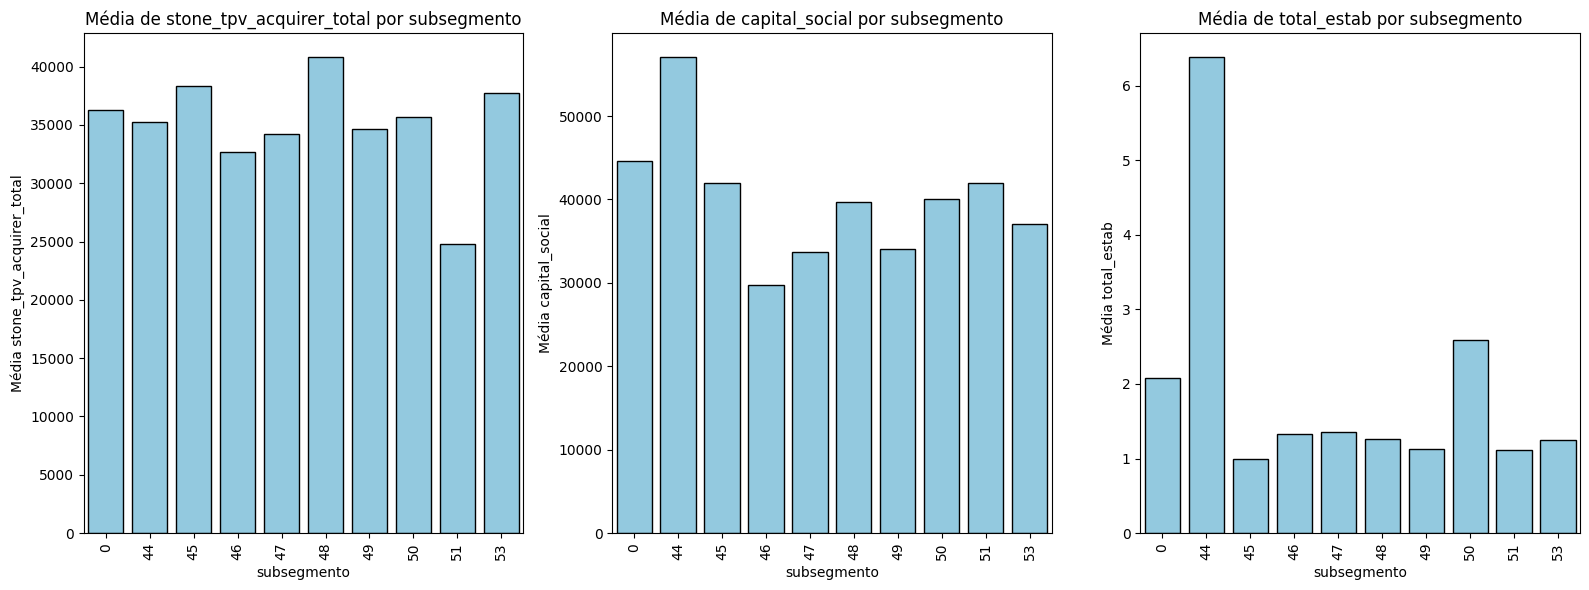

In [132]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'subsegmento',10)

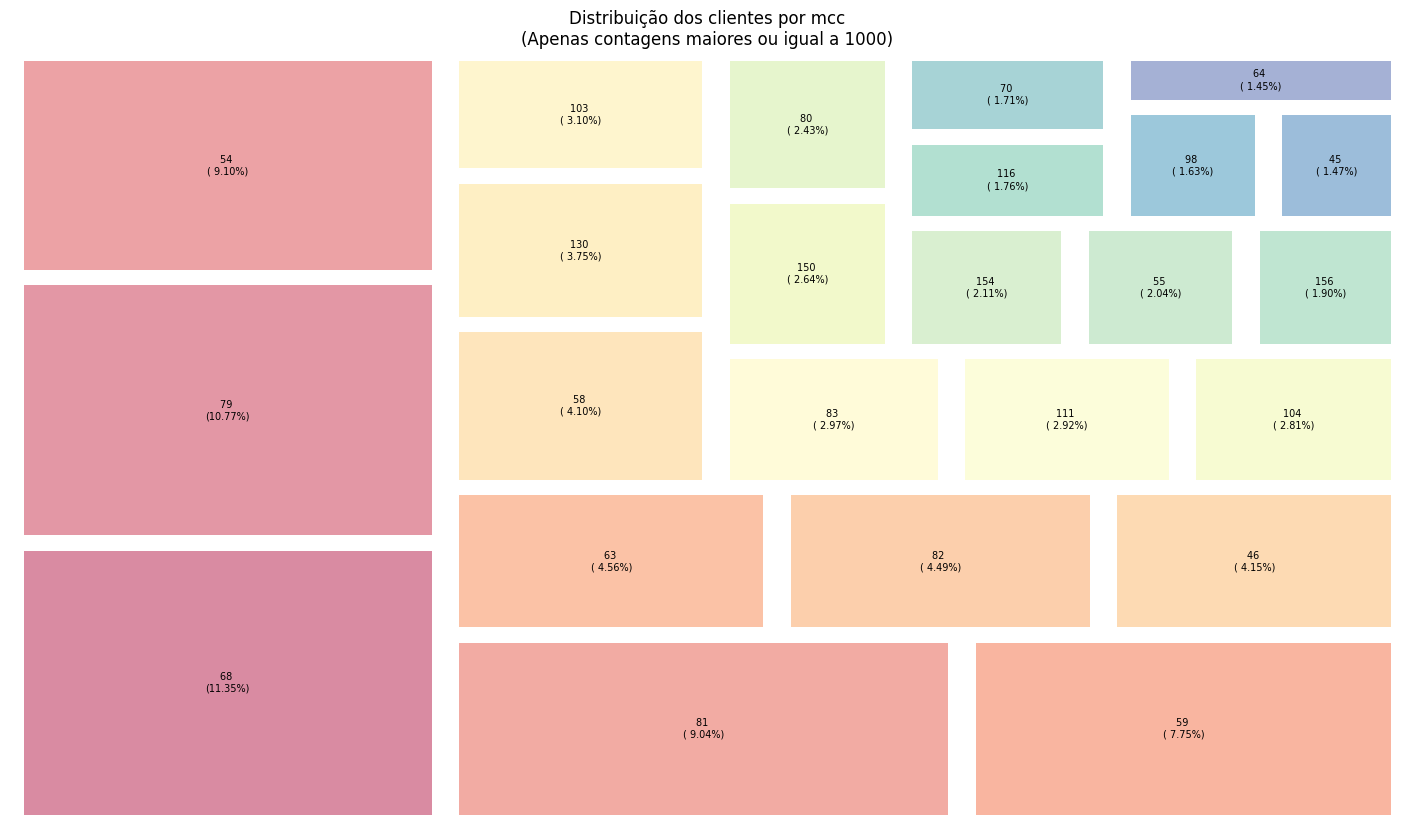

In [253]:
# Distribuição do mcc
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)

tabela_mcc = pd.DataFrame(df['mcc'].value_counts()).reset_index().rename(columns = {'count':'contagem'})

filtered_tabela_mcc = tabela_mcc[tabela_mcc['contagem'] >= 1000]

perc = [str('{:5.2f}'.format(i / filtered_tabela_mcc['contagem'].sum() * 100)) + "%" for i in filtered_tabela_mcc['contagem']]

rotulos = [f'{i[0]} \n({i[1]})' for i in zip(filtered_tabela_mcc['mcc'], perc)]

squarify.plot(sizes=filtered_tabela_mcc['contagem'], label=rotulos, color=sns.color_palette('Spectral', len(filtered_tabela_mcc['contagem'])), alpha=0.5, pad=1, text_kwargs={'fontsize': 7}, ax=ax)

plt.axis('off')
plt.title(f"Distribuição dos clientes por mcc\n(Apenas contagens maiores ou igual a 1000)")
plt.show()

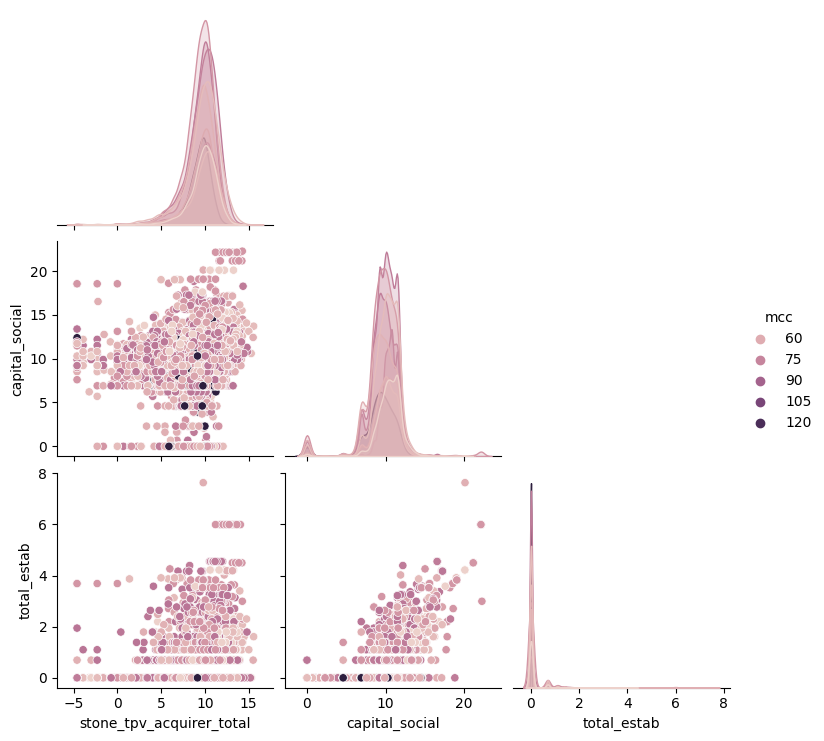

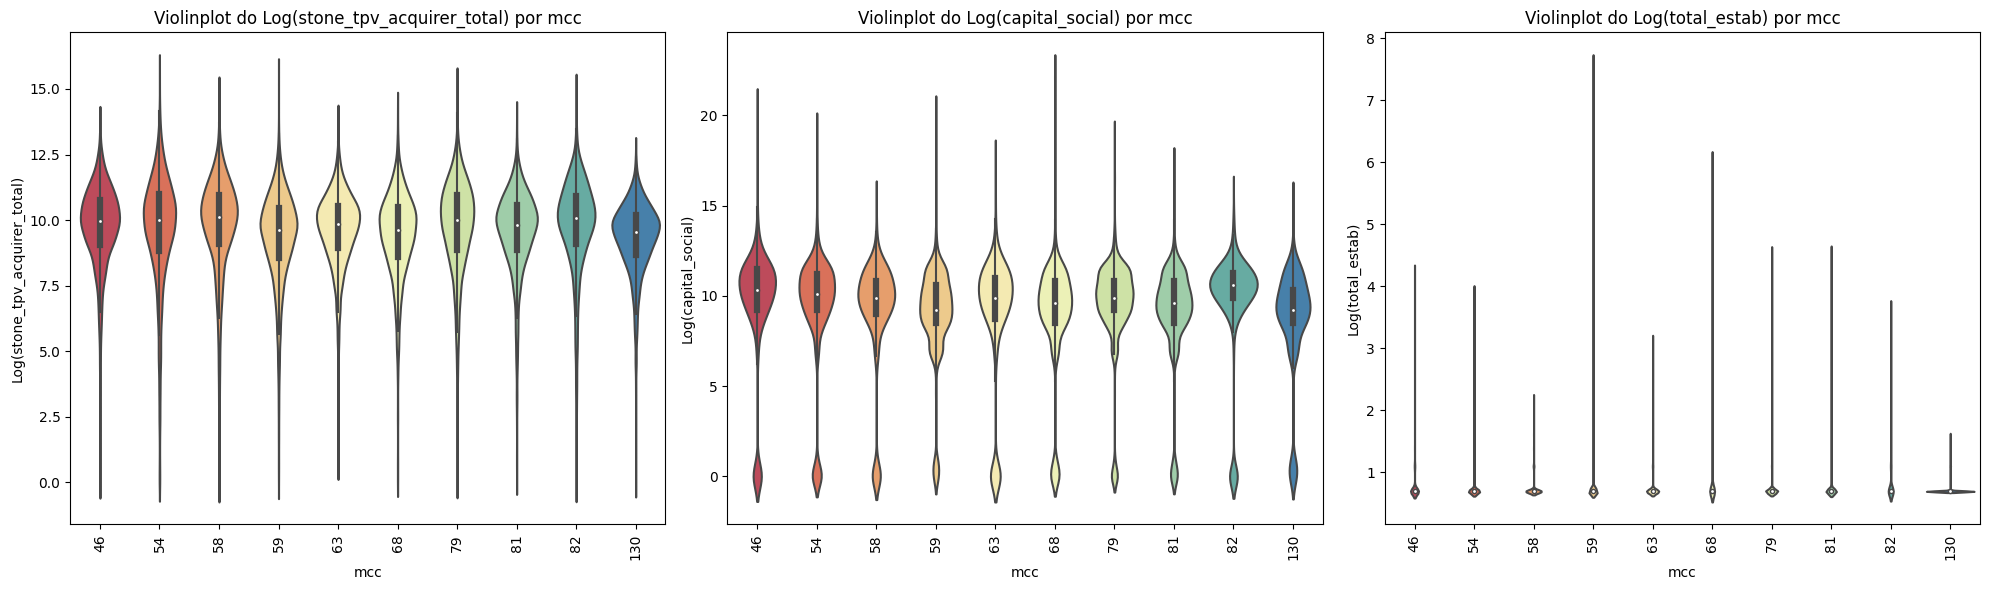

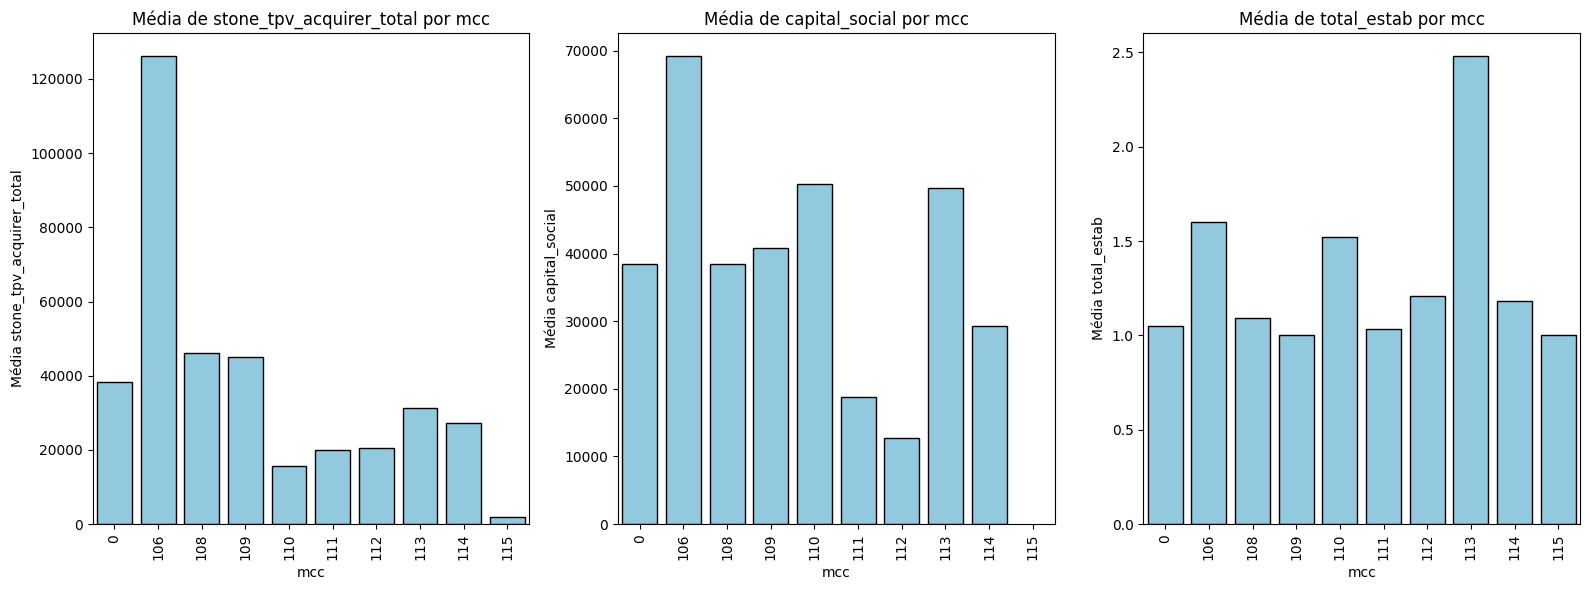

In [133]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'mcc',10)

In [14]:
df_tmp['mei'].value_counts(normalize=True)

mei
0    0.79057
1    0.20943
Name: proportion, dtype: float64

In [36]:
df_tmp.groupby('mei')[['stone_tpv_acquirer_total']].sum()/df_tmp['stone_tpv_acquirer_total'].sum()

stone_tpv_acquirer_total
mei                          
0                     0.93545
1                     0.06455

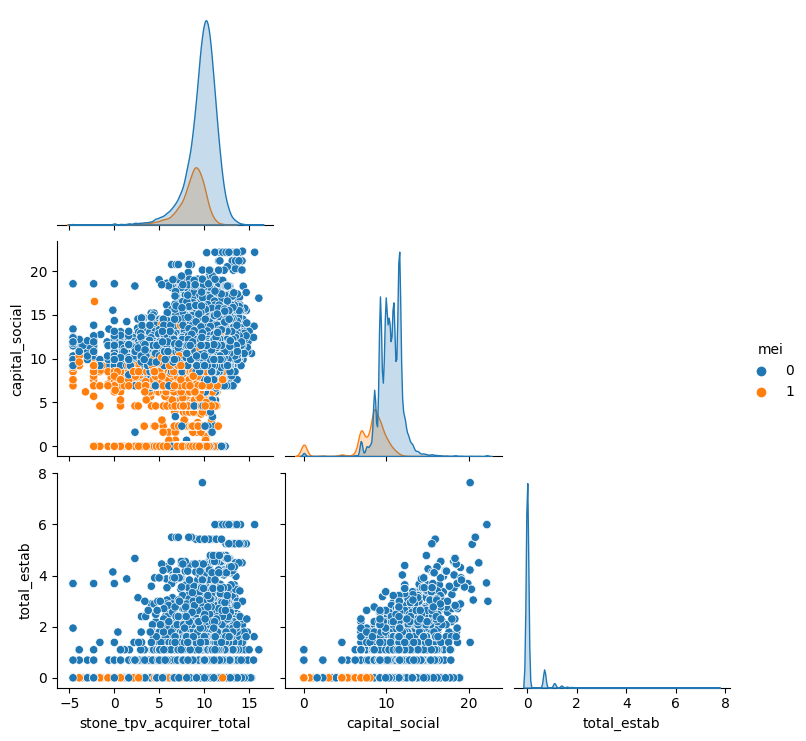

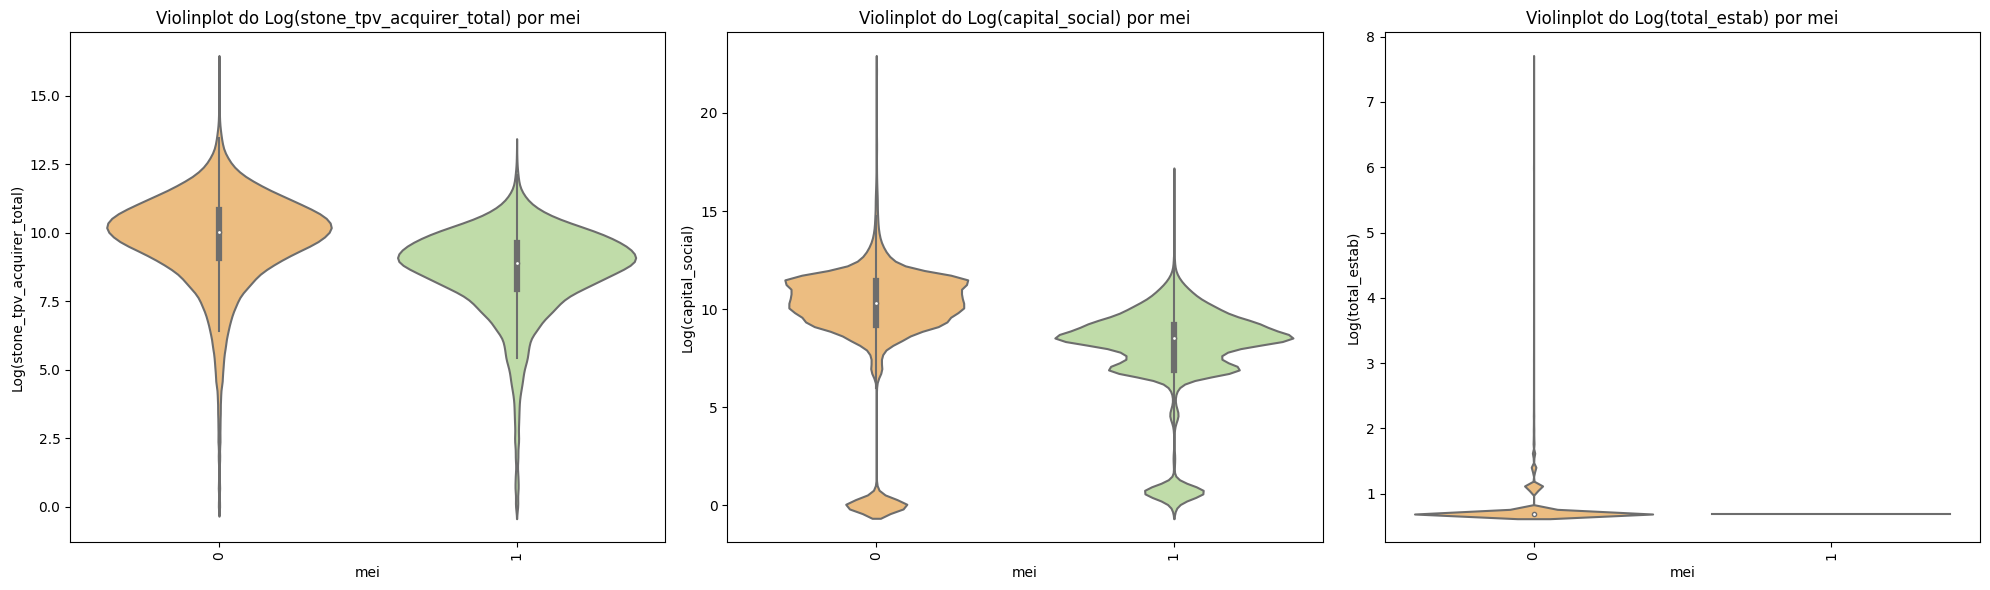

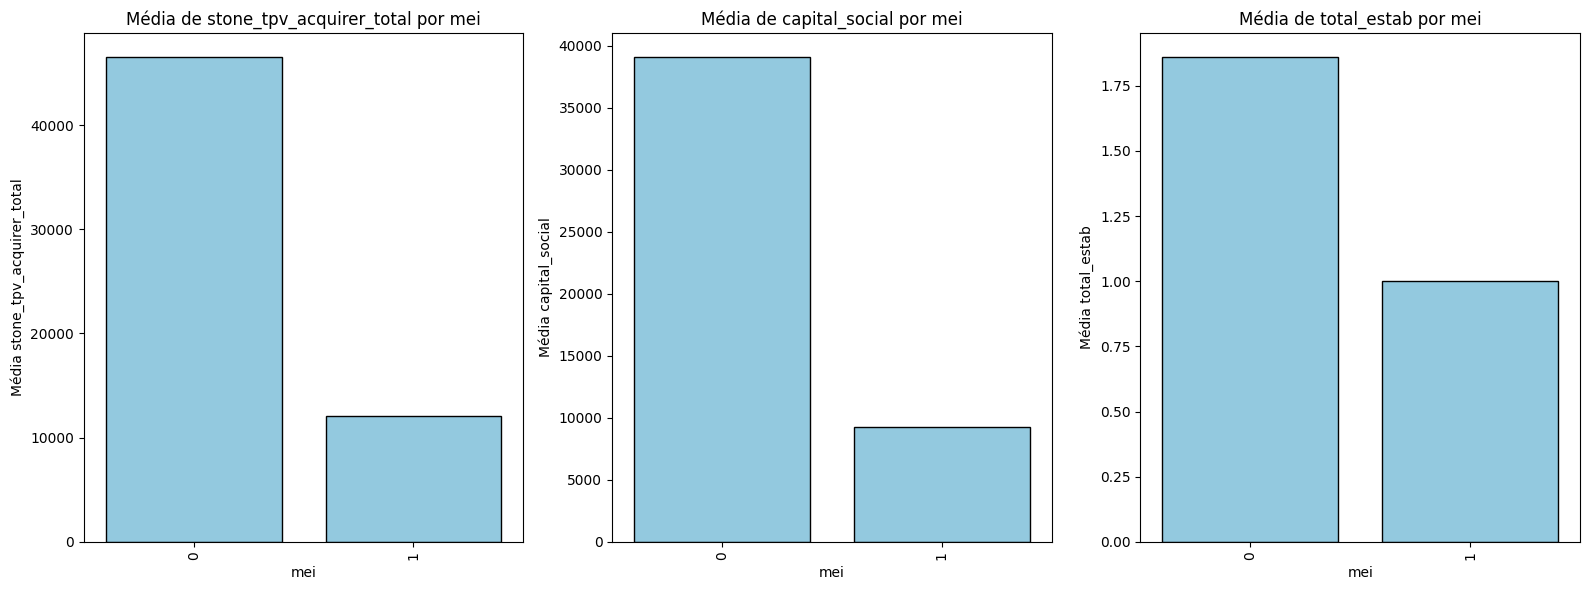

In [153]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'mei')

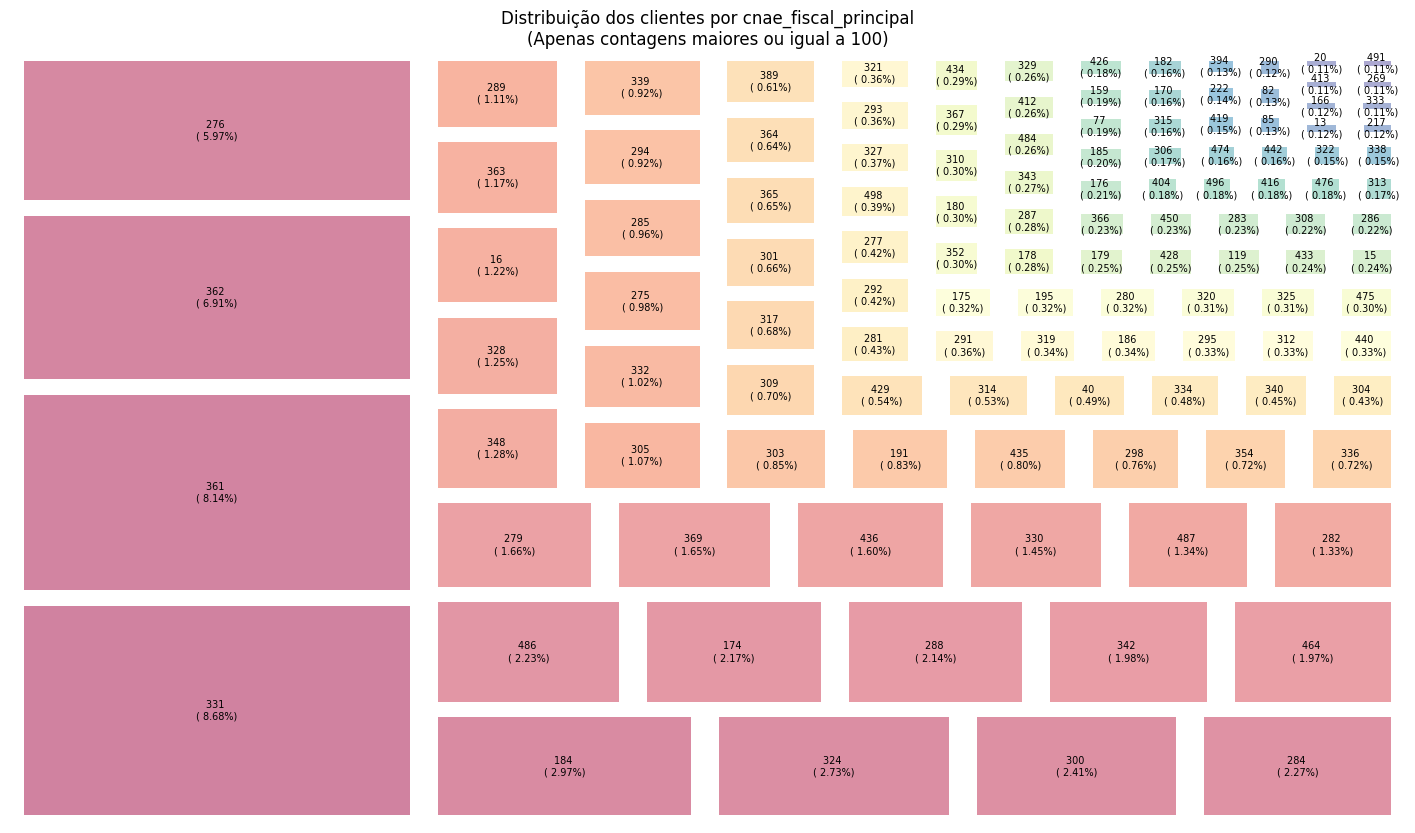

In [159]:
# Distribuição dos CNAE
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)

tabela_mcc = pd.DataFrame(df_tmp['cnae_fiscal_principal'].value_counts()).reset_index().rename(columns = {'count':'contagem'})

filtered_tabela_mcc = tabela_mcc[tabela_mcc['contagem'] >= 100]

perc = [str('{:5.2f}'.format(i / filtered_tabela_mcc['contagem'].sum() * 100)) + "%" for i in filtered_tabela_mcc['contagem']]

rotulos = [f'{i[0]} \n({i[1]})' for i in zip(filtered_tabela_mcc['cnae_fiscal_principal'], perc)]

squarify.plot(sizes=filtered_tabela_mcc['contagem'], label=rotulos, color=sns.color_palette('Spectral', len(filtered_tabela_mcc['contagem'])), alpha=0.5, pad=1, text_kwargs={'fontsize': 7}, ax=ax)

plt.axis('off')
plt.title(f"Distribuição dos clientes por cnae_fiscal_principal\n(Apenas contagens maiores ou igual a 100)")
plt.show()

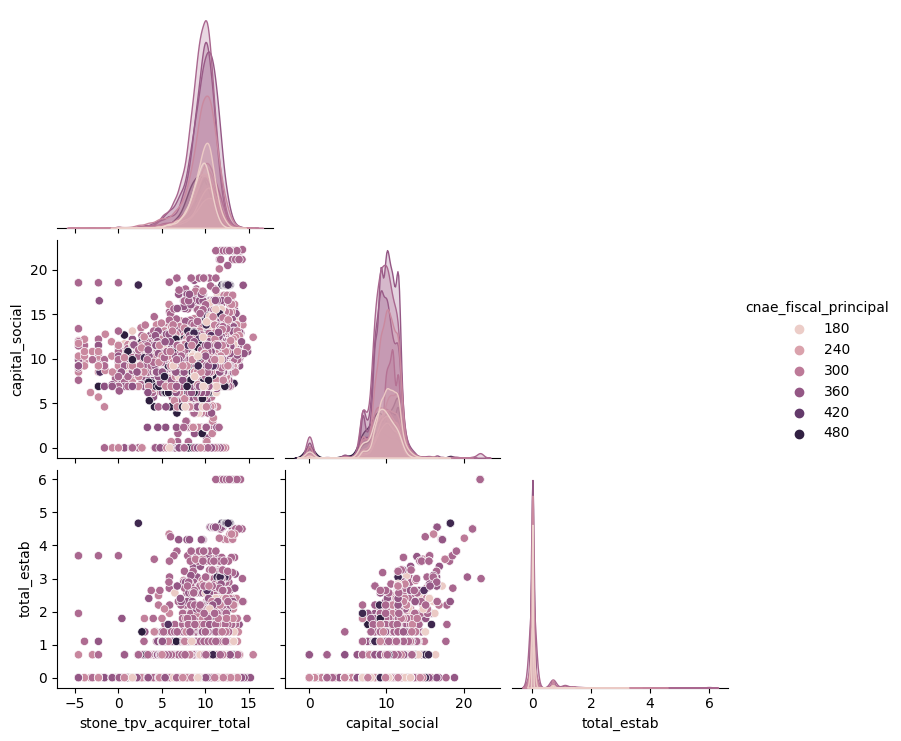

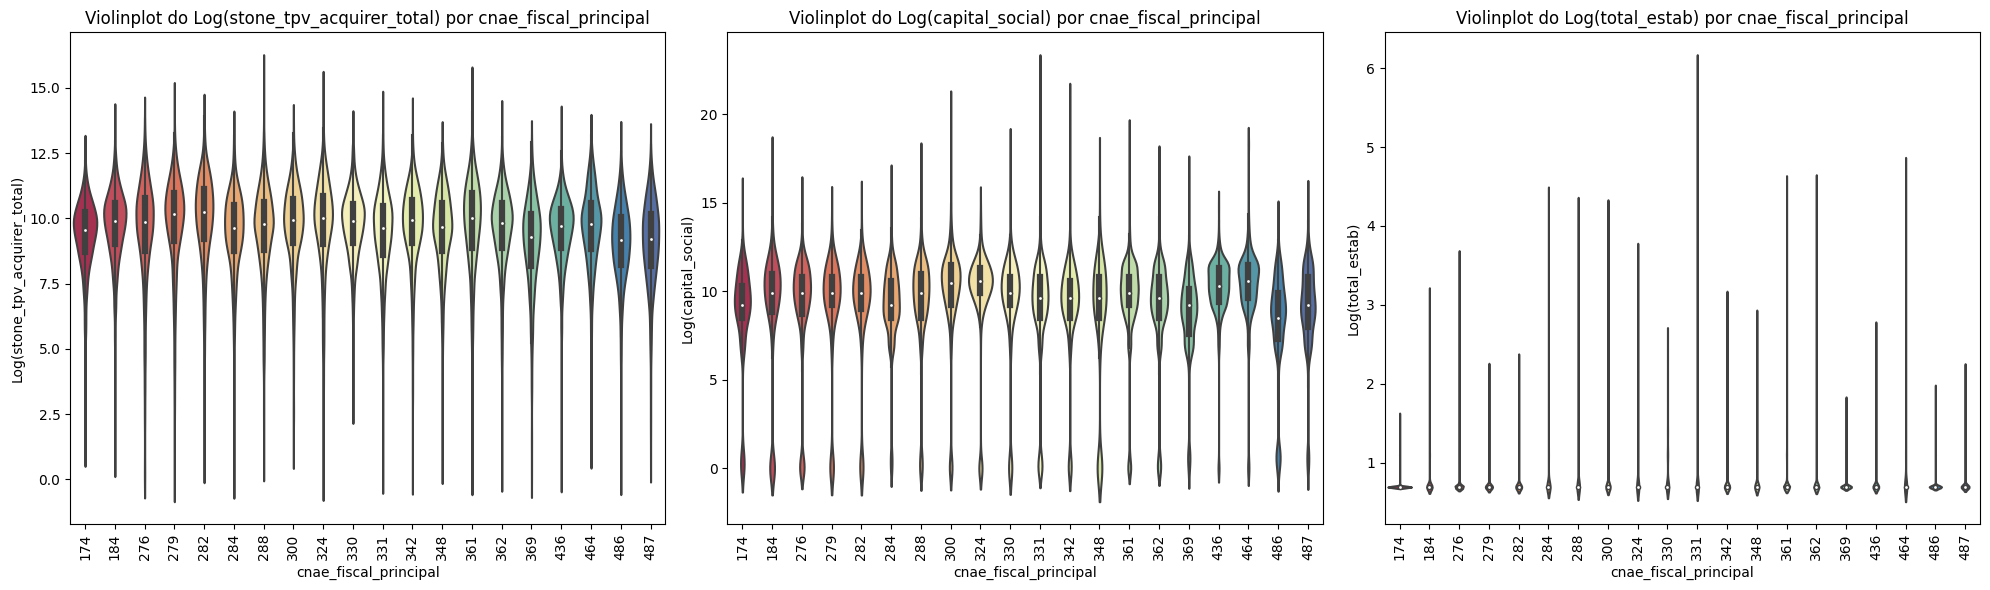

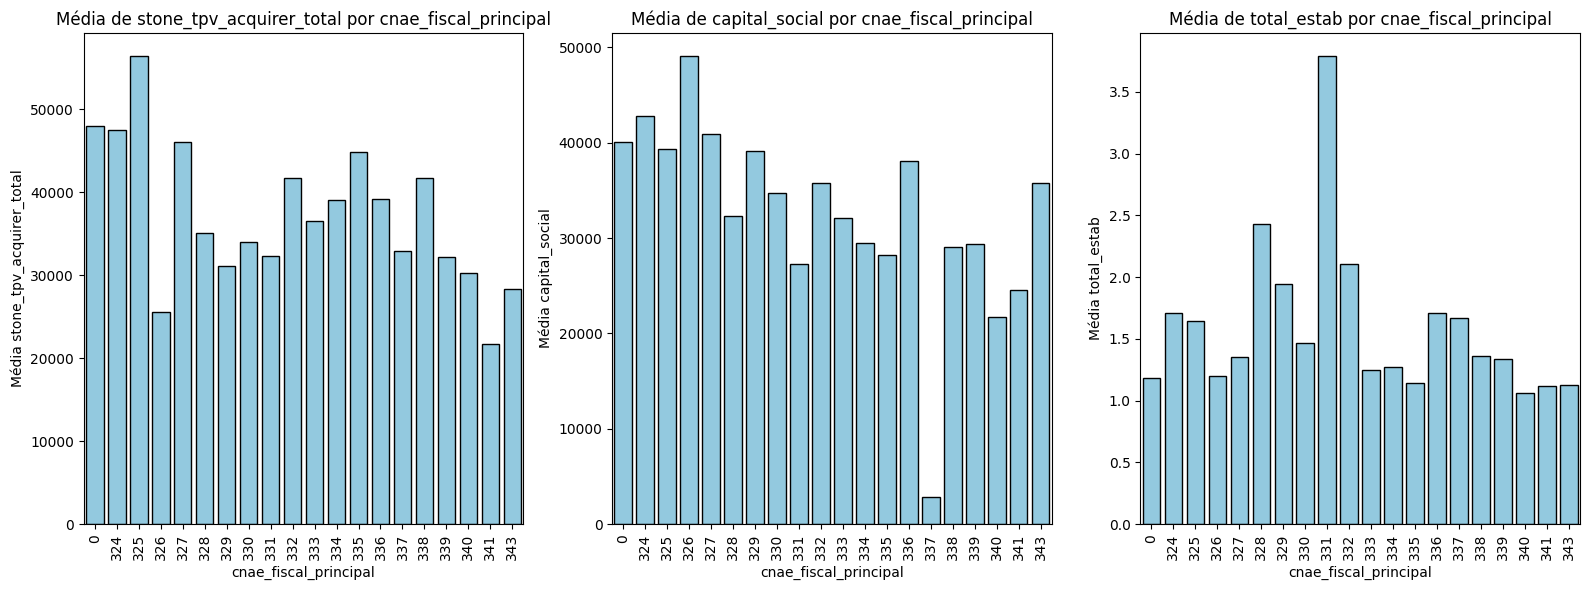

In [156]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social', 'total_estab'],'cnae_fiscal_principal',20)

Pela definição das variáveis acima, há grandes de chances de termos alguma espécie de redundância com tantos códigos indicando a mesma coisa.
Vamos realizar um teste Qui Quadrado afim de tentar reduzir a quantidade de variáveis que utilizaremos em nossa modelagem

In [58]:
# Teste de Qui-Quadrado
columns = ['segmento', 'subsegmento', 'mcc', 'mei', 'cnae_fiscal_principal']


data_cat = df_tmp[columns]
chi2_results = []

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        contingency_table = pd.crosstab(data_cat[columns[i]], data_cat[columns[j]])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        chi2_results.append({'Variable1': columns[i], 'Variable2': columns[j], 'Chi2': chi2, 'P-value': p})

chi2_results_df = pd.DataFrame(chi2_results)

# Variáveis com alta correspondência (pp-valur menor que 0.05)
highly_correlated_variables = chi2_results_df[chi2_results_df['P-value'] < 0.05]

print("Variáveis categóricas com alta correspondência:")
print(highly_correlated_variables)


Variáveis categóricas com alta correspondência:
     Variable1              Variable2          Chi2  P-value
0     segmento            subsegmento  2.700000e+06      0.0
1     segmento                    mcc  2.700000e+06      0.0
2     segmento                    mei  7.072882e+03      0.0
3     segmento  cnae_fiscal_principal  2.700000e+06      0.0
4  subsegmento                    mcc  7.000000e+06      0.0
5  subsegmento                    mei  9.697598e+03      0.0
6  subsegmento  cnae_fiscal_principal  7.000000e+06      0.0
7          mcc                    mei  1.204170e+04      0.0
8          mcc  cnae_fiscal_principal  1.650000e+07      0.0
9          mei  cnae_fiscal_principal  1.555098e+04      0.0


* Como imaginado todas as categorias tem altíssima correspondência, mas manteremos todas as variáveis em nossa modelagem num primeiro momento

**Conclusões**

* As variávels categóricas consistem em classificações de diversos tipos (nacionais, globais, internas, etc)
* Relação das categorias com as variáveis numéricas é evidente, principalmente para **TPV** e **Capital Social**
* Devido a possível redundância entre tantas categorias iremos levar isso em conta na hora da modelagem
* A classe 1 de **mei** (clientes que são de fato mei) representa 20% dos dados e apenas 6% do valor total do **TPV**

## 2.3 - Variável Tier

Vamos tentar entender a relação da variável tier com as variáveis numéricas e categóricas de nossos dados

Vamos primeiro olhar para as variáveis categóricas e entender a relação entre tier e elas através de testes de Qui-Quadrado

In [59]:
# Teste de Qui-Quadrado
columns = ['segmento', 'subsegmento', 'mcc', 'mei', 'cnae_fiscal_principal',
           'uf','municipio','bairro',
            'faixa_empregados','porte' ,'tier']


data_cat = df_tmp[columns]

# Executa o teste de qui-quadrado para cada variável categórica em relação a 'tier'
chi2_results = []
for col in columns[:-1]:  # Exclui 'tier' da análise
    contingency_table = pd.crosstab(data_cat[col], data_cat['tier'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results.append({'Variable': col, 'Chi2': chi2, 'P-value': p})

# Cria um DataFrame com os resultados do teste de qui-quadrado
chi2_results_df = pd.DataFrame(chi2_results)

# Variáveis com alta correspondência (p-value menor que 0.05)
highly_correlated_variables = chi2_results_df[chi2_results_df['P-value'] < 0.05]

print("Variáveis categóricas com alta correspondência:")
print(highly_correlated_variables)


Variáveis categóricas com alta correspondência:
                Variable          Chi2        P-value
0               segmento   8840.094259   0.000000e+00
1            subsegmento  13270.101686   0.000000e+00
2                    mcc  15120.184929   0.000000e+00
3                    mei  26443.287235   0.000000e+00
4  cnae_fiscal_principal  19404.069837   0.000000e+00
5                     uf   1083.490733  9.970906e-163
6              municipio  15818.871077   1.057533e-03
8       faixa_empregados  25064.293184   0.000000e+00
9                  porte  48738.706235   0.000000e+00


In [61]:
from scipy.stats import f_oneway, spearmanr

# Seleciona as colunas com as variáveis numéricas e 'tier'
columns_numeric = ['stone_tpv_acquirer_total', 'capital_social', 'total_estab', 'tier']
data_numeric = df_tmp[columns_numeric].dropna()

# Teste ANOVA para 'stone_tpv_acquirer_total' em relação a 'tier'
anova_stone_tpv = f_oneway(data_numeric[data_numeric['tier'] == 0]['stone_tpv_acquirer_total'],
                           data_numeric[data_numeric['tier'] == 1]['stone_tpv_acquirer_total'],
                           data_numeric[data_numeric['tier'] == 2]['stone_tpv_acquirer_total'],
                           data_numeric[data_numeric['tier'] == 3]['stone_tpv_acquirer_total'],
                           data_numeric[data_numeric['tier'] == 4]['stone_tpv_acquirer_total'])

# Teste ANOVA para 'capital_social' em relação a 'tier'
anova_capital_social = f_oneway(data_numeric[data_numeric['tier'] == 0]['capital_social'],
                                data_numeric[data_numeric['tier'] == 1]['capital_social'],
                                data_numeric[data_numeric['tier'] == 2]['capital_social'],
                                data_numeric[data_numeric['tier'] == 3]['capital_social'],
                                data_numeric[data_numeric['tier'] == 4]['capital_social'])

# Teste ANOVA para 'total_estab' em relação a 'tier'
anova_total_estab = f_oneway(data_numeric[data_numeric['tier'] == 0]['total_estab'],
                             data_numeric[data_numeric['tier'] == 1]['total_estab'],
                             data_numeric[data_numeric['tier'] == 2]['total_estab'],
                             data_numeric[data_numeric['tier'] == 3]['total_estab'],
                             data_numeric[data_numeric['tier'] == 4]['total_estab'])

# Correlação de Spearman entre 'tier' e 'stone_tpv_acquirer_total'
spearman_stone_tpv = spearmanr(data_numeric['tier'], data_numeric['stone_tpv_acquirer_total'])

# Correlação de Spearman entre 'tier' e 'capital_social'
spearman_capital_social = spearmanr(data_numeric['tier'], data_numeric['capital_social'])

# Correlação de Spearman entre 'tier' e 'total_estab'
spearman_total_estab = spearmanr(data_numeric['tier'], data_numeric['total_estab'])

print("Teste ANOVA para stone_tpv_acquirer_total:", anova_stone_tpv)
print("Teste ANOVA para capital_social:", anova_capital_social)
print("Teste ANOVA para total_estab:", anova_total_estab)
print("Correlação de Spearman para stone_tpv_acquirer_total:", spearman_stone_tpv)
print("Correlação de Spearman para capital_social:", spearman_capital_social)
print("Correlação de Spearman para total_estab:", spearman_total_estab)


Teste ANOVA para stone_tpv_acquirer_total: F_onewayResult(statistic=6246.246960358316, pvalue=0.0)
Teste ANOVA para capital_social: F_onewayResult(statistic=21316.432174685564, pvalue=0.0)
Teste ANOVA para total_estab: F_onewayResult(statistic=26828.31749881612, pvalue=0.0)
Correlação de Spearman para stone_tpv_acquirer_total: SignificanceResult(statistic=0.4179667002021386, pvalue=0.0)
Correlação de Spearman para capital_social: SignificanceResult(statistic=0.22235519017608918, pvalue=0.0)
Correlação de Spearman para total_estab: SignificanceResult(statistic=0.12538236178001638, pvalue=0.0)


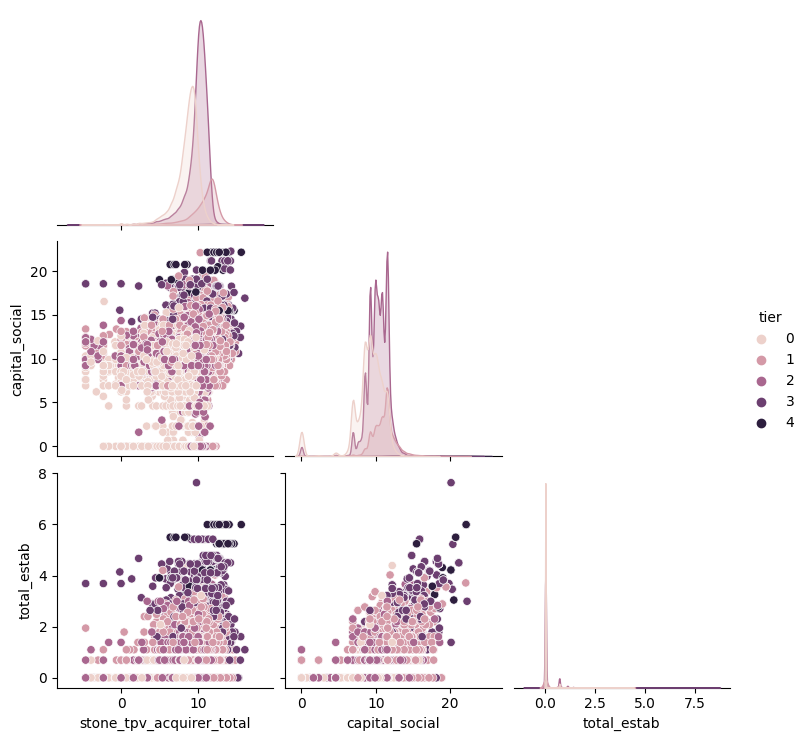

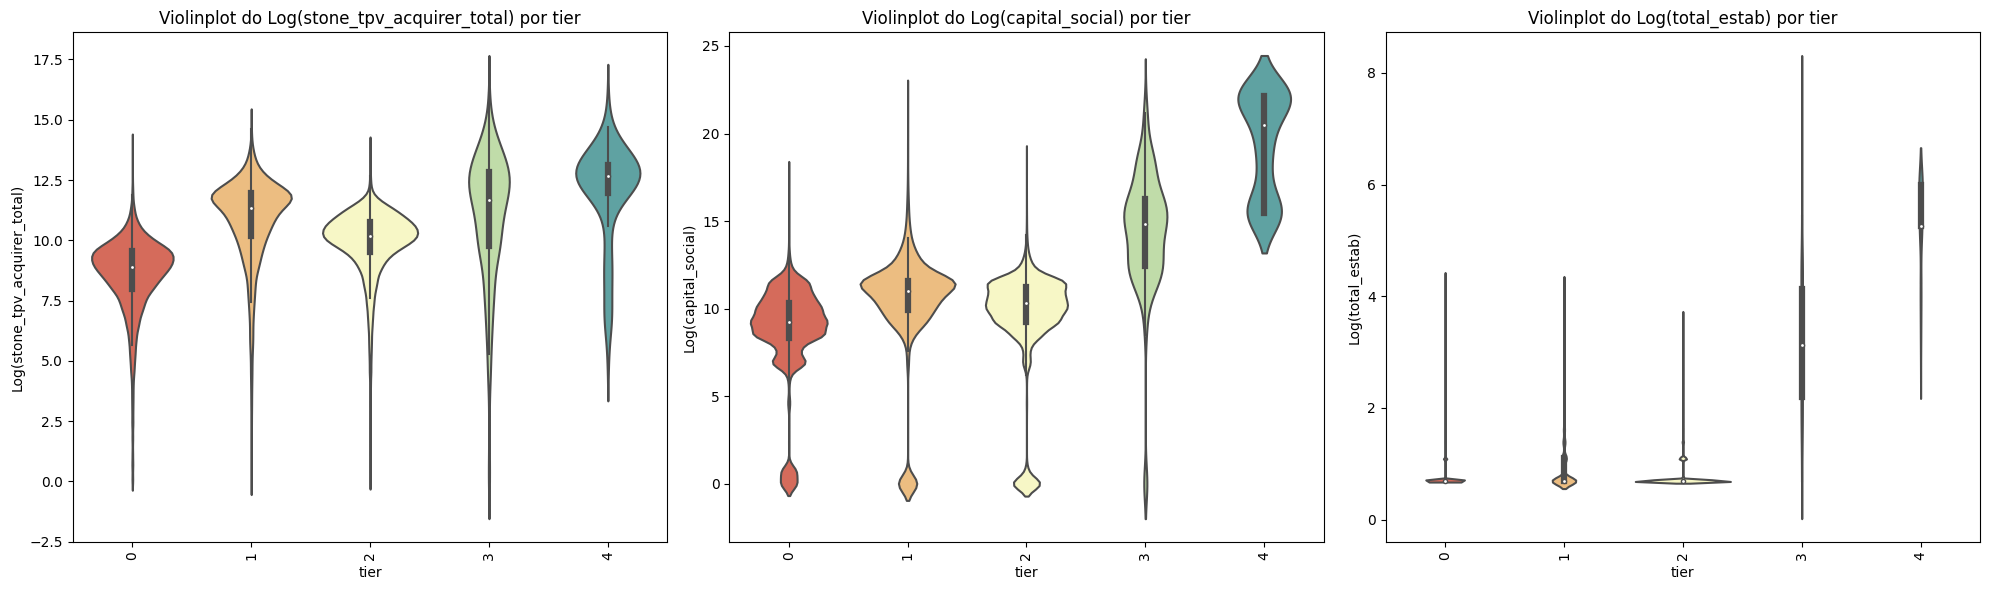

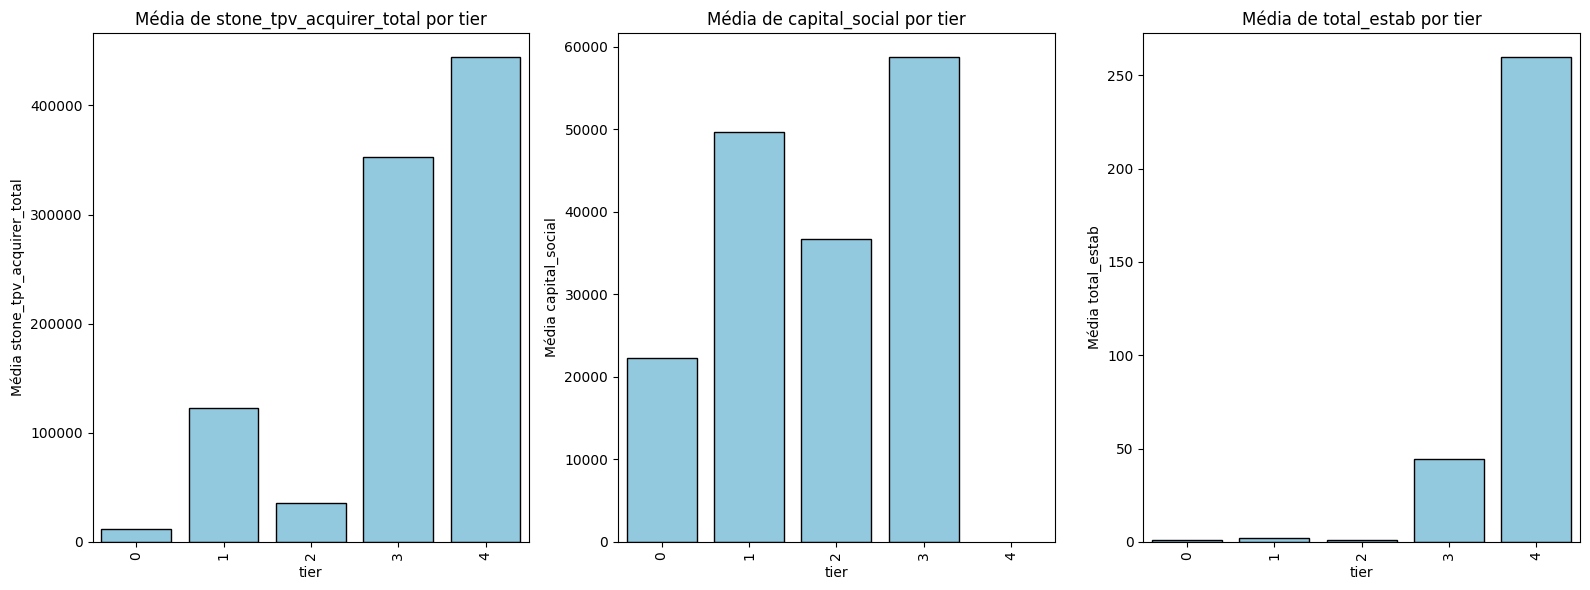

In [66]:
plot_combined(df_tmp,['stone_tpv_acquirer_total','capital_social','total_estab'],'tier')

**Conclusões**
* Tier possui alta correspondência com todas as variáveis categóricas, sendo a menor correspondência entre Tier e UF
* O teste ANOVA e o cálculo da correlação de Spearman nos indica que há uma relação positiva entre a Tier e as variáveis numéricas
* Podemos assumir que Tier consiste em alguma espécie de classificação interna, sendo tier 0 a classificação mais baixa e 4 a mais alta